# Modeling the New York City Civilian Complaint Review Board and Auditing the Model Fairness

# The Inputs, Outputs, Decisions Being Made, and Relationship Between Decisions and True Outcome

The New York City Civilian Complaint Review Board (CCRB), the system in this context, is an agency independent from the New York Police Department that investigates complaints against NYPD officers regarding allegations of excessive or unnecessary force, abuse of authority, discourtesy, or offensive language. 
Civilians can file complaints to the CCRB online, in-person, over the phone, or via mail. In the online form, the inputs include information regarding the complainant, details regarding the incident, any information on the victim(s)/witness(es) if the complainant is not sole victim, and any information regarding the accused officer. Complainants can also submit any supporting documents. Throughout the investigation process, the review board may obtain further evidence from the NYPD (e.g., body camera footage) and conduct interviews of any complainants, victims, witnesses, and officers involved. Specific complainant/victim attributes collected include age, gender, and ethnicity. The complainant may also provide details on the officer's sex, race, and physical appearance.

The dataset only contains information regarding the complainant, the accused officer, and the nature of the complaint/allegation. It also contains general information regarding the complaint itself, like the dates it was submitted and closed and the precinct it took place in. The dataset does not include any additional evidence obtained after the complaint was filed (e.g., interviews). 

The output of the decision-making system is the same as the decision being made – the disposition. Put simply, the CCRB chooses to “substantiate,” meaning “there was a preponderance of evidence that the acts alleged occurred and constituted misconduct,” a complaint or not (Title 38-A: Civilian Complaint Review Board - New York City 2018). Since the decision-making system (the CCRB) is deciding whether the allegations occurred, the true outcome is whether the CCRB is actually correct. In other words, the true outcome is whether the alleged actions in question (one complaint can have multiple allegations) actually occurred, whereas the output/decision made by the CCRB is only the result of their investigations and taken as a proxy for the ground truth. 

# Model Card

## Description of the Model
To replicate this classification of complaints into substantiated or unsubstantiated, a logistic regression modle with L2 regularization was used. To train the model, a simple 75%-25% train-test split was used. One parameter used is the `class_weight` parameter, which assigns a weight to each class that the model uses for penalizing. The class weights calculated using `n_samples / n_classes * np.bincount(substantiated)` help combat the class imbalance in the dataset (only about 25% of the observations are substantiated) and make substantiated observations more important for the model. The features used in the model are `contact_reason` (or text indicating why the officer approached the civilian), `mos_ethinicity` (officer's ethnicity), `rank_incident` (officer's rank at time of incident), `mos_gender` (officer's gender), `complainant_gender` (complainant's gender), `mos_age_incident` (officer's age at time of incident), `complainant_age_incident` (complainant's age at time of incident). `borough` (the borough in which the incident took place), `black` (whether the complainant is Black), `allegation` (brief description of the allegation), `fado_type` (type of complaint), and time/date related features (`month_received`, `year_received`, `month_closed`, and `year_closed`). All categorical features except `allegation` and `fado_type` were one-hot encoded while the exceptions were ordinal encoded. The numerical features were scaled.

## Intended Use 
Primary intended uses: This model would be used to help determine whether a given allegation should be substantiated or not. An allegation is substantiated if there is enough evidence to determine that the alleged action(s) happened and violated NYPD rules. Presumably, the model would not be the sole decision maker in this context; investigators would use the outcome of the model as supplementary information. 

Intended users: The intended users of this model is the New York City Civilian Complaints Review Board and its Board members. Since the CCRB is independent of the NYPD, people affiliated with the NYPD should not use this model to, for example, try and predict if behavior against a given civilian would result in punishment. 

Out of-scope use cases: Any use cases related to the law enforcement system (e.g., use by the police departments or criminal courts) would be out of scope. Since this model is designed specifically for civilian complaints, it should not be used in relation to criminal activity. Furthermore, the CCRB only investigates complaints in the four specific categories aforementioned, so any complaints that fall outside of the CCRB’s jurisdiction would be out-of-scope for this model. 

## Factors

### Relevant factors
One of the most relevant groups of this dataset and the model is complainant ethnicity. As described more in depth in Paper 1, policing in the United States has a racially charged background that continues to affect how Americans are policed. Given disparities in policing across different neighborhoods and different groups’ perceptions of the police, we can assume that people of different ethnicities interact with the police in different ways. Additionally, despite only making up around 20% of NYC’s population, Black people made up most complainants in the dataset the model is built on (New York City Department of City Planning | Population Division, 2022). Thus, the model's performance will be looked at for Black complainants vs. non-Black complainants.

### Evaluation factors: 
Complainant ethnicity is the factor reported because of its apparent relevance in the distribution of the dataset and dispositions of complaints (whether a complaint is substantiated or not). The historical significance of ethnicity in the context of policing make this factor important to consider. 

## Evaluation Data
Datasets: The dataset used for training and testing comes from ProPublica and consists of 31,686 unique complaints to the New York Police Department submitted by 11,312 complainants for the Civilian Complaint Review Board’s review from January 2000 to January 2020 (*The NYPD Files*, 2020). Each complaint comes with information regarding the complainant’s demographics, the police oﬀicer’s information and demographics, the nature of the complaint and the alleged action in question, and whether the CCRB deemed the allegation as substantiated. 

Motivation: This dataset was introduced to me through DSC 80, so having done previous analysis with this dataset, I chose to continue analyzing the dataset. Its context is highly relevant to today’s society and discussion on policing in the United States.

Preprocessing: Before creating the model, the allegations column was simplified so that it can be binned. All categorical variables were one hot or ordinal encoded and all quantitative variables were scaled. The disposition column (target variable) was also simplified to simply include substantiated and not substantiated. The complainant ethnicity column was binned into Black and non-Black.  

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import datetime
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

In [7]:
complaints = pd.read_csv('allegations_cleaned.csv')
complaints_og = pd.read_csv('allegations.csv')
for col in ['year_received','month_received','year_closed','month_closed']:
    complaints[col] = complaints_og[col]
complaints = complaints.loc[complaints.year_received >= 2000]

In [8]:
complaints['substantiated'] = complaints.board_disposition.apply(
        lambda d: 1 if 'Substantiated' in d else 0)

In [9]:
complaints.drop(columns=['Unnamed: 0'],inplace=True)

In [10]:
precinct_map = pd.read_csv('precinct_borough.csv')
precinct_map['Precinct_num'] = precinct_map['Precinct'].str.extract(r'([0-9]*)')
precinct_map = precinct_map[['Precinct_num','borough']]
precinct_map = precinct_map.loc[precinct_map.Precinct_num!='']
precinct_map = pd.Series(precinct_map.borough.values,index=precinct_map.Precinct_num.astype(int)).to_dict()
precinct_map[-1] = np.nan
precinct_map[''] = np.nan
complaints.precinct = complaints.precinct.replace({1000.0:-1, 
                                                   np.nan:-1,
                                                  14:-1,
                                                  18:-1,
                                                  22:-1}).astype(int)
complaints['borough'] = complaints.precinct.replace(precinct_map)

In [370]:
def transform_dates(X):
    '''
    method to transform date columns to get time elapsed 
    '''
    df = pd.DataFrame(X)
    cols = ['year_received','month_received','year_closed','month_closed']
    df['received'] = df.apply(
        lambda row: datetime.
        datetime(year=row[0], month=row[1], day=1), axis=1)
    df['closed'] = df.apply(
        lambda row: datetime.
        datetime(year=row[2], month=row[3], day=1), axis=1)
    df['elapsed'] = (df['closed'] - df['received'])
    return df['elapsed'].apply(lambda day: day.days).to_frame()

In [371]:
def transform_allegation(X):
    '''
    function that simplifies/bins the allegation column
    '''
    # possible bins for allegation
    allegation_categories = ['restricted','gun','chokehold','beat',
        'sex','sexual','threat','arrest','physical',
        'frisk','search','retaliatory','stop',
        'property','premises','premise',
        'refusal','seizure','vehicle','question','word','other'][::-1]
    lower = X['allegation'].str.lower()
    return lower.apply(lambda string: 
            string if string in allegation_categories[1:] else 'other').to_frame()

In [372]:
def transform_ethnicity(X):
    '''
    function that binarizes board_disposition column
    '''
    transformed = X['complainant_ethnicity']
    return transformed.apply(
        lambda d: 1 if d=='Black' else 0).to_frame()

In [373]:
complaints['black'] = complaints.complainant_ethnicity == 'Black'

In [374]:
complaints['brooklyn'] = complaints.borough == 'brooklyn'

In [854]:
# nominal variables
baseline_feats_categ = ['contact_reason','mos_ethnicity','mos_gender','complainant_gender','borough','rank_incident']

# ordinal and/or engineered variables
categ = ['allegation','fado_type']
# quantitiative variable
baseline_feats_num = ['complainant_age_incident','mos_age_incident', 
                     'black']
# date columns to find time elapsed
baseline_dates = ['year_received','month_received','year_closed','month_closed']
# categories for fado_type ordinal encoding
fado_categories = ['Abuse of Authority','Force','Discourtesy','Offensive Language'][::-1]
# drop all missing data
model_df = complaints.dropna()
X = model_df[baseline_feats_categ+baseline_feats_num+categ+baseline_dates]
# split data into training and test sets
X_tr, X_ts, y_tr, y_ts = train_test_split(X,
        model_df['substantiated'],random_state=1)

In [855]:
def preprocessor():
    '''
    function containing all preprocessing/transformation of features
    done before fitting the model
    '''
    baseline_feats_categ = ['contact_reason','mos_ethnicity','rank_incident','mos_gender','complainant_gender','borough']
    categ = ['allegation','fado_type']
    baseline_feats_num = ['complainant_age_incident','mos_age_incident', 'black']
    baseline_dates = ['year_received','month_received','year_closed','month_closed']
    # all possible values of fado_type
    fado_categories = ['Abuse of Authority','Force',
                       'Discourtesy','Offensive Language'][::-1]
    ranks = ['Police Officer', 'Detective', 'Sergeant', 
'Lieutenant','Captain', 'Deputy Inspector','Inspector']
    
    # use age as is
    age = Pipeline(steps=[
        ('age', FunctionTransformer()),
        ('scaled', StandardScaler())
        ])
    # one hot encode nominal columns
    categs = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore',sparse=True)) 
        ])
    # calculate time elapsed 
    elapsed = Pipeline(steps=[
        ('elapsed', FunctionTransformer(transform_dates)),
        ('scaled', StandardScaler())
        ])
    # ordinal encode fado 
    fado = Pipeline(steps=[
        ('fado', OrdinalEncoder(categories=[fado_categories]))
        ])
    # simplify/bin allegation, then use ordinal encoding
    alleg = Pipeline(steps=[
        ('transform', FunctionTransformer(transform_allegation, validate=False)),
        ('alleg', OrdinalEncoder())
        ])
    
    # binarize complainant_ethnicity
    eth = Pipeline(steps=[
        ('transform', FunctionTransformer(transform_ethnicity, validate=False))
        ])
    preproc = ColumnTransformer(
        transformers=[
            ('age', age, baseline_feats_num),
            ('elapsed', elapsed, baseline_dates),
            ('categs', categs, baseline_feats_categ),
            ('fad', fado, ['fado_type']),
            ('alleg', alleg, ['allegation'])])
    return preproc

In [856]:
# weights as inverse of distribution

weights = {0: model_df.shape[0] / (2 * (complaints.substantiated.value_counts()[0])), 1:model_df.shape[0] / (2 * (complaints.substantiated.value_counts()[1]))}

pl = Pipeline(steps=[('preprocessor', preprocessor()),
                    ('classifier', LogisticRegression(random_state = 88, class_weight=weights))])
fitted = pl.fit(X_tr, y_tr)

In [857]:
model_results_training = X_tr.copy()

In [858]:
training_results = pl.predict_proba(X_tr)

In [859]:
model_results_training['proba'] = training_results[:,1]

In [860]:
model_results_training['ccrb'] = y_tr

## Metrics

### Model performance measures
Accuracy is not the focus of this model because of the class imbalance in the data. Since 75% of allegations were unsubstantiated, the model could theoretically predict the negative class all the time and achieve a decent accuracy of 75%. Instead, recall is one of the primary model performance metrics. Since the CCRB is independent of the NYPD and wants to encourage civilians to file complaints if they feel they’ve been victims of police misconduct, the model should prioritize substantiating all complaints that should be substantiated. The CCRB rarely substantiates any allegations, so a model that attempts to find all complaints that should be substantiated would be a large improvement from the previous decision-making system. However, it is also important that the CCRB doesn’t recklessly substantiate too many underserving complaints because the board has a reputation to uphold. If the board makes too many mistakes, then neither the NYPD nor the civilians would be well served. This is why precision is also important for this model. So since recall and precision are important, the F1-score, or the harmonic mean of recall and precision, is the primary metric. 

### Decision thresholds 
In order to choose a suitable threshold for all complaints, different utility functions were compared, as demonstrated in *Fairness & Algorithmic Decision Making* (Fraenkel). The utility function calculates weighted accuracy as a means to compare different thresholds and weights. In this model, a positive prediction corresponds to substantiation, which yields the positive utility (sense of justice) for the complainant. Thus, positive predictions should be weighed at least as much as negative predictions (unsubstantiated). Since we do not have access to the ground truth (whether the alleged action actually occured/if the CCRB is correct), the CCRB's decision is used as a proxy for it and is used to calculated utility. 

At weights 0.0-0.3, the utility is higher for thresholds lower than 0.5, while for weights 0.4-1.0, utility is higher for thresholds above 0.5. This means that when substantiation's weight isn't much higher than unsubstantiation's, the threshold is at least 0.5. When substantiation is weighted over 2x as more important the unsubstantiation, the threshold is below 0.5. Since the CCRB was designed to deal with police misconduct, substantiating complaints and ensuring officers are reprimanded for misconduct is a higher priority than ensuring complainants cannot recklessly submit false complaints. With this in mind and how utility fluctuates as described above and in the graphs, a weight of 0.4 seems reasonable. This weight indicates that substantiation is over 2x more important than unsubstantiation. 

In [861]:
def calc_utility(df, thresh, wt):
    '''
    sample weight: weights a positive different from a negative
    if you scored >= threshold --> positive prediction
    wt: weight of a positive of a reoffense
    - in this case, negatives are weighted as more important
        CCRB: would be different!
    - 
    accuracy_score(y_true, y_pred, sample_weight=None)
    '''

    return metrics.accuracy_score(
        df['ccrb'], 
        (df.proba >= thresh).astype(int), 
        sample_weight=df['ccrb'].replace({1: 1, 0:wt})
    )

def find_best_thresh(df, wt=0.5):
    
    thresh, util = 0, 0
    for k in np.arange(0.1, 1.1, 0.001):
        m = calc_utility(df, k, wt)
        if m >= util:
            util = m
            thresh = k
    
    return thresh, util

In [862]:
df = model_results_training[['black', 'borough', 'proba', 'ccrb']]

In [863]:
a = pd.DataFrame(
    {str(round(w,2)):[calc_utility(df, t, w) for t in np.arange(0.1, 1.1, 0.1)] 
     for w in np.arange(0,1.01,0.1)}
).T

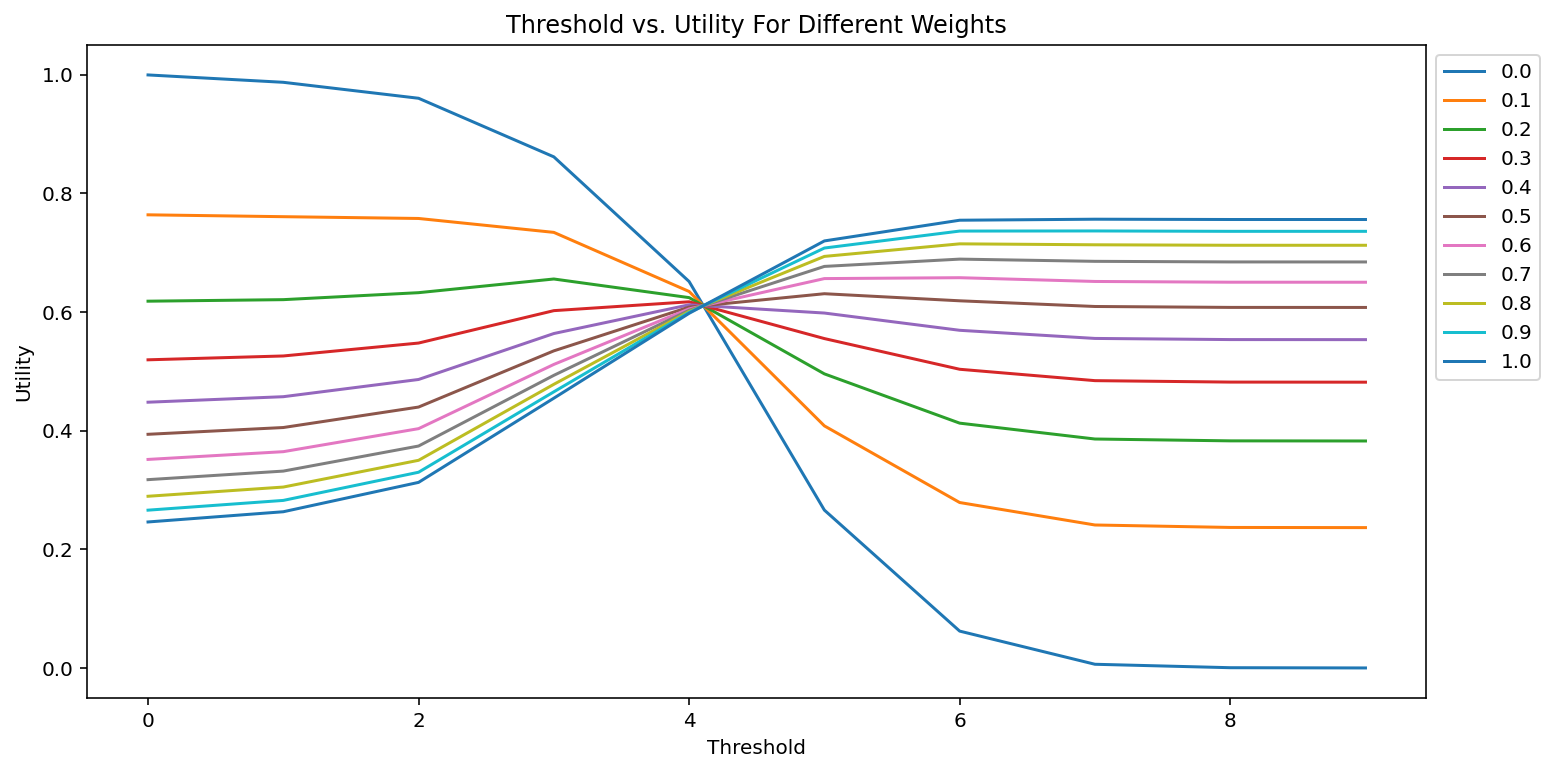

In [864]:
ax = a.T.plot(figsize=(12,6))
ax.legend(bbox_to_anchor=(1., 1.), bbox_transform=ax.transAxes);
plt.title('Threshold vs. Utility For Different Weights')
plt.xlabel('Threshold')
plt.ylabel('Utility')
plt.show()

With a weight of 0.4, the threshold that maximizes utility is 0.527. As shown in the ROC curve below, for the training set, a threshold of 0.527 yields a false positive rate of 0.33 and a true positive rate of 0.56. 

In [865]:
best_threshold, utility = find_best_thresh(df,0.4)

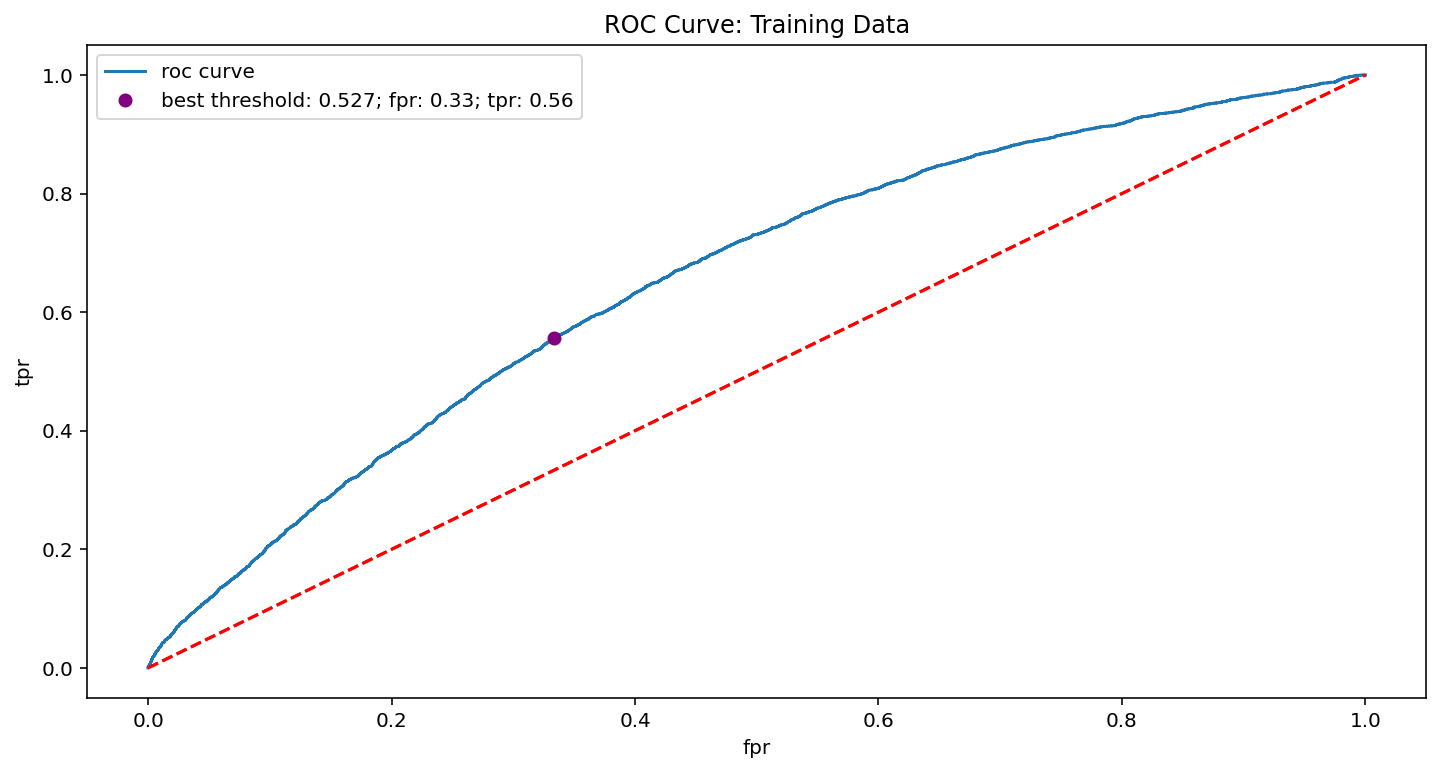

In [867]:
fpr, tpr, thresholds = metrics.roc_curve(model_results_training.ccrb,model_results_training.proba)
best_index = list(thresholds).index(list(filter(lambda x: np.isclose(x, best_threshold, atol=0.0001), thresholds))[0])
ax = pd.DataFrame(tpr, index=fpr).plot(legend=False, title='ROC Curve: Training Data',figsize=(12,6))
legend = ['roc curve', 'best threshold']
ax.plot([fpr[best_index]], [tpr[best_index]], 'ro', color = 'purple')
plt.xlabel('fpr')
plt.ylabel('tpr')
best_threshold = round(thresholds[best_index],3)
fpr_best = round(fpr[best_index],2)
tpr_best = round(tpr[best_index],2)
legend = ['roc curve', 'best threshold: {}; fpr: {}; tpr: {}'.format(best_threshold,fpr_best, tpr_best)]
plt.legend(legend)
ax.plot([(0,0), (1,1)], 'r--');

In [868]:
# weights as inverse of distribution
weights = {0: model_df.shape[0] / (2 * (complaints.substantiated.value_counts()[0])), 1:model_df.shape[0] / (2 * (complaints.substantiated.value_counts()[1]))}

pl = Pipeline(steps=[('preprocessor', preprocessor()),
                    ('classifier', LogisticRegression(random_state = 88, class_weight=weights))])
pl.fit(X_tr, y_tr)
results = (pl, pl.predict_proba(X_ts)[:,1]>=best_threshold)
score = metrics.accuracy_score(y_ts, results[1])

# Performance Metrics

Unitary Results: The performance of the model for Black complainants was slightly better than non-Black complainants in terms of accuracy, but the test recall and precision were much better for the non-Black complainants than the Black complainants. This may mean that the model does a better job at detecting negative cases in general. Since there are more negative cases in the original dataset for Black complainants, accuracy for Black complainants is stronger but the metrics that look at the positive classes (precision and recall) are lower. There is a higher proportion of positive classes for non-Black complainants, so this may be why the model's precision and recall is stronger for non-Black complainants.

In [869]:
# performance
print('Test Performance Metrics For All Groups:')
print(f'Accuracy Score: {metrics.accuracy_score(y_ts,results[1])}')
print(f'Recall score: {metrics.recall_score(y_ts,results[1])}')
print(f'Precision score: {metrics.precision_score(y_ts,results[1])}')
print(f'F1 score: {metrics.f1_score(y_ts,results[1])}')

Test Performance Metrics For All Groups:
Accuracy Score: 0.623882406425216
Recall score: 0.526413921690491
Precision score: 0.3299571484222828
F1 score: 0.4056513409961685


In [870]:
X_tr_black = X_tr.loc[X_tr.black == True]
y_tr_black = y_tr.loc[X_tr_black.index]
X_tr_nb = X_tr.loc[X_tr.black != True]
y_tr_nb = y_tr.loc[X_tr_nb.index]
test = model_df.loc[list(y_ts.index)]
test_black = test.loc[test.black==True]
test_nb = test.loc[(test.black!=True)]
X_ts_black = test_black[baseline_feats_categ+baseline_feats_num+categ+baseline_dates]
X_ts_nb = test_nb[baseline_feats_categ+baseline_feats_num+categ+baseline_dates]
y_ts_nb = y_ts.loc[X_ts_nb.index]
y_ts_black = y_ts.loc[X_ts_black.index]

In [871]:
results = (pl, pl.predict_proba(X_ts_black)[:,1]>=best_threshold)

# performance
print('Test Performance Metrics For Black Complainants:')
print(f'Accuracy Score: {metrics.accuracy_score(y_ts_black,results[1])}')
print(f'Recall score: {metrics.recall_score(y_ts_black,results[1])}')
print(f'Precision score: {metrics.precision_score(y_ts_black,results[1])}')
print(f'F1 score: {metrics.f1_score(y_ts_black,results[1])}')

Test Performance Metrics For Black Complainants:
Accuracy Score: 0.6321701720841301
Recall score: 0.49948400412796695
Precision score: 0.31469440832249673
F1 score: 0.3861188671719187


In [872]:
results = (pl, pl.predict_proba(X_ts_nb)[:,1]>=best_threshold)
# performance
print("Test Performance Metrics for non-Black Complainants")
print(f'Accuracy Score: {metrics.accuracy_score(y_ts_nb,results[1])}')
print(f'Recall score: {metrics.recall_score(y_ts_nb,results[1])}')
print(f'Precision score: {metrics.precision_score(y_ts_nb,results[1])}')
print(f'F1 score: {metrics.f1_score(y_ts_nb,results[1])}')

Test Performance Metrics for non-Black Complainants
Accuracy Score: 0.6095238095238096
Recall score: 0.5671875
Precision score: 0.35276967930029157
F1 score: 0.4349910125823847


In [41]:
X_tr_bk_black = X_tr.loc[(X_tr.borough == 'brooklyn') & (X_tr.black == True)]
X_tr_bk_nb = X_tr.loc[(X_tr.borough == 'brooklyn') & (X_tr.black != True)]
X_tr_nbk_black = X_tr.loc[(X_tr.borough != 'brooklyn') & (X_tr.black == True)]
X_tr_nbk_nb = X_tr.loc[(X_tr.borough != 'brooklyn') & (X_tr.black != True)]

y_tr_bk_black = y_tr.loc[X_tr_bk_black.index]
y_tr_bk_nb = y_tr.loc[X_tr_bk_nb.index]
y_tr_nbk_black = y_tr.loc[X_tr_nbk_black.index]
y_tr_nbk_nb = y_tr.loc[X_tr_nbk_nb.index]

test = model_df.loc[list(y_ts.index)]
test_bk_black = test.loc[(test.borough=='brooklyn') & (test.black == True)]
test_nbk_black = test.loc[(test.borough!='brooklyn') & (test.black == True)]
test_bk_nb = test.loc[(test.borough=='brooklyn') & (test.black != True)]
test_nbk_nb = test.loc[(test.borough!='brooklyn') & (test.black != True)]

X_ts_bk_black = test_bk_black[baseline_feats_categ+baseline_feats_num+categ+baseline_dates]
X_ts_nbk_black = test_nbk_black[baseline_feats_categ+baseline_feats_num+categ+baseline_dates]
X_ts_bk_nb = test_bk_nb[baseline_feats_categ+baseline_feats_num+categ+baseline_dates]
X_ts_nbk_nb = test_nbk_nb[baseline_feats_categ+baseline_feats_num+categ+baseline_dates]

y_ts_bk_black = y_ts.loc[X_ts_bk_black.index]
y_ts_nbk_black = y_ts.loc[X_ts_nbk_black.index]
y_ts_bk_nb = y_ts.loc[X_ts_bk_nb.index]
y_ts_nbk_nb = y_ts.loc[X_ts_nbk_nb.index]

In [770]:
def print_metrics(X_ts, y_ts):
    results = (pl, pl.predict_proba(X_ts)[:,1]>=best_threshold)
    score = metrics.accuracy_score(y_ts, results[1])
    # performance
    print(f'Accuracy Score: {metrics.accuracy_score(y_ts,results[1])}')
    print(f'Recall score: {metrics.recall_score(y_ts,results[1])}')
    print(f'Precision score: {metrics.precision_score(y_ts,results[1])}')
    print(f'F1 score: {metrics.f1_score(y_ts,results[1])}')

## Ethical Considerations 
The data contains three protected classes – complainant/officer ethnicity, complainant/officer gender, and complainant/officer age. While the model’s intended use doesn’t involve anything that’s central to human life, one may argue that civilians should have the right to critique and make complaints against the policing body. For the sake of this exercise, no risks or harms were explicitly considered during model building; this may be addressed in the audit. This model could theoretically be used to punish or not punish an officer that has broken the rules or give/deny civilians who were victims of police misconduct a sense of justice,  so its use case can have some considerable ramifications on one’s life. Furthermore, since the CCRB is a government body, a model such as this one that uses protected classes may not be apporpriate; the CCRB may be legally obliged to omit these proected classes.

## Caveats and Recommendations 
If this model were to be used by the CCRB, it should not replace the investigation and input of the board, but may be used as an ancillary factor in the ultimate disposition. As for caveats of the dataset, the limited view of complainant ethnicity (e.g., doesn’t consider Afro-Latino people) could mean that a significant group in NYC’s population wasn’t explicitly considered. Since about 75%  of complaints fall in the negative class (unsubstantiated), it would be ideal that we use a dataset with more balanced classes for both training and testing. 

# Parity Measures, Utility, and Fairness
In this context, utility refers to the sense of justice a complainant, who feels that they're a victim of police misconduct, receives when their complaint(s) get substantiated. Actual utility would be the result the model yields. While not observable, effort-based utility can refer to the ground truth; if a reported incident actually happened, then the complaint should be substantiated and the complainant should receive that sense of justice. 

Accuracy: In Paper 1, it was mentioned that accuracy parity isn’t a strong parity metric to enforce because a model that either substantiates all complaints or unsubstantiates all complaints would satisfy accuracy parity, but not be useful in reality. Similarly, accuracy itself is not a strong performance metric because of the class imbalance; an accuracy of 75% may sound strong, but the model could just be predicting unsubstantiated every time an achieve this accuracy. The model above achieved a test accuracy of about 63%. For comparison, the COMPAS algorithm which involves the criminal justice system had an accuracy of about 68% (Julia Angwin, 2016). A machine learning algorithm predicting Supreme Court behavior had about 70% accuracy (Katz et al.). Considering the limited data and minimal feature engineering, an accuracy of 63% doesn’t seem wholly unreasonable. 

Recall: Maximizing recall would maximize utility (sense of justice) for the complainants. However, if recall is maximized and there are some false positives, innocent police officers may be unjustly penalized. The model yielded a test recall score of about 52%, meaning the model correctly classified 52% of all substantiated complaints in the test set. 52% of these complainants would rightfully receive a sense of justice (the utility) from this model, while the remaining 48% of missed out true substantiated cases wouldn’t. 

Precision: Since there is a tradeoff between recall and precision, the test precision is only 33%. This means that the model correctly predicted the positive class for 33% of complaints. The false positive complaints would mean that the alleged police officers would lose utility because of the punishment they would receive and potential damage to their reputation. A low precision score isn’t necessarily detrimental to complainants, so long as complaints that should in reality be substantiated are correctly classified, regardless of the false positive rate. On the other hand, a low precision may mean a lot of false positives, which would mean a lot of police officers are wrongfully reprimanded. However, one may argue that since the CCRB is independent of the NYPD that their priority should be civilian utility. 


## Demographic Parity

For demographic parity, we expect the model rates of substantiation to be equal across complainant ethnicity and borough. Enforcing demographic parity implies that effort-based utility is actually constant across all groups. In this context, that would mean that all complainants, whether or not their complaint is true, have an intrinsic right to be substantiated by the CCRB. Assuming that no group is more likely to submit a false complaint, this notion of constant effort-based utility can hold.

In [50]:
model_results = X_ts.copy()
model_results['classification'] = pl.predict_proba(X_ts)[:,1] >= best_threshold
model_results['probability'] = pl.predict_proba(X_ts)[:,1] 

In [51]:
model_results['brooklyn'] = model_results.borough=='brooklyn'

In Paper 1, the data showed that complaints submitted by Black complainants were substantiated about 2% less of the time than complaints submitted by non-Black complainants. The model yielded an even stronger violation of demographic parity by ethnicity. The rate of positive classification (substantiation) for complaints submitted by Black complainants is 6% less than that for complaints submitted by non-Black complainants, a difference that is significantly different from 0 by permutation test at significance level 0.05. The model amplified the disparity seen in the original dataset.

In [427]:
# pivot table showing number of complaints of each disposition for black and nonblack complainants
nb_sub = model_results.pivot_table(index='black', 
                        columns='classification', aggfunc='size',fill_value=0)
sums = nb_sub.sum(axis=1)
# calculate the proportions of complaints submitted by black and nonblack complainants
# that got substantiated
nb_sub['Substantiated'] =  nb_sub[1] / sums
nb_sub['Not Substantiated'] =  nb_sub[0] / sums
# proportion of all complaints filed by black complainants and nonblack complainants 
prop_black_comp = model_results.loc[model_results['black']].shape[0]/model_results.shape[0]
print('Model Substantiation Rates for Black Complainants vs. non-Black Complainants')
nb_sub['Overall Proportion'] = [1-prop_black_comp, prop_black_comp]
nb_sub[['Substantiated', 'Overall Proportion']]

Model Substantiation Rates for Black Complainants vs. non-Black Complainants


classification,Substantiated,Overall Proportion
black,,
False,0.426087,0.365965
True,0.367591,0.634035


In [428]:
observed = nb_sub['Substantiated'][True]-nb_sub['Substantiated'][False]
print('Observed Difference in Model Substantiation Rate for Black vs. non-Black Complainants: {}'.format(observed))

Observed Difference in Model Substantiation Rate for Black vs. non-Black Complainants: -0.05849613434200679


In [429]:
def permutation_test(df, observed, n_repetitions):
    test_statistics = []
    for _ in range(n_repetitions):
        # shuffle the statistic of interest
        shuffled_values = (df['black'].sample(replace=False, frac=1)
            .reset_index(drop=True))
        # put them in a table
        shuffled = df.copy().reset_index()
        shuffled['Shuffled Values'] = shuffled_values
        # compute the group differences (test statistic!)
        # difference in means:
        nb_disposition = shuffled.pivot_table(index='Shuffled Values', 
                            columns='classification', aggfunc='size',fill_value=0)
        sums = nb_disposition.sum(axis=1)
        nb_disposition['Substantiated'] =  nb_disposition[1] / sums
        difference = nb_disposition['Substantiated'][1]-nb_disposition['Substantiated'][0]
        # add it to the list of results
        test_statistics.append(difference)
    # p-value to see if got any thing even smaller than observed
    p_value_neg = np.count_nonzero(np.array(test_statistics) < min([observed, observed*-1])) / n_repetitions
    # p-value to see if got any thing even bigger than observed
    p_value_pos = np.count_nonzero(np.array(test_statistics) > max([observed, observed*-1])) / n_repetitions
    p_value = p_value_neg + p_value_pos
    return (test_statistics, p_value)

In [430]:
test_statistics_eth, p_value_eth = permutation_test(model_results, observed, 1000)

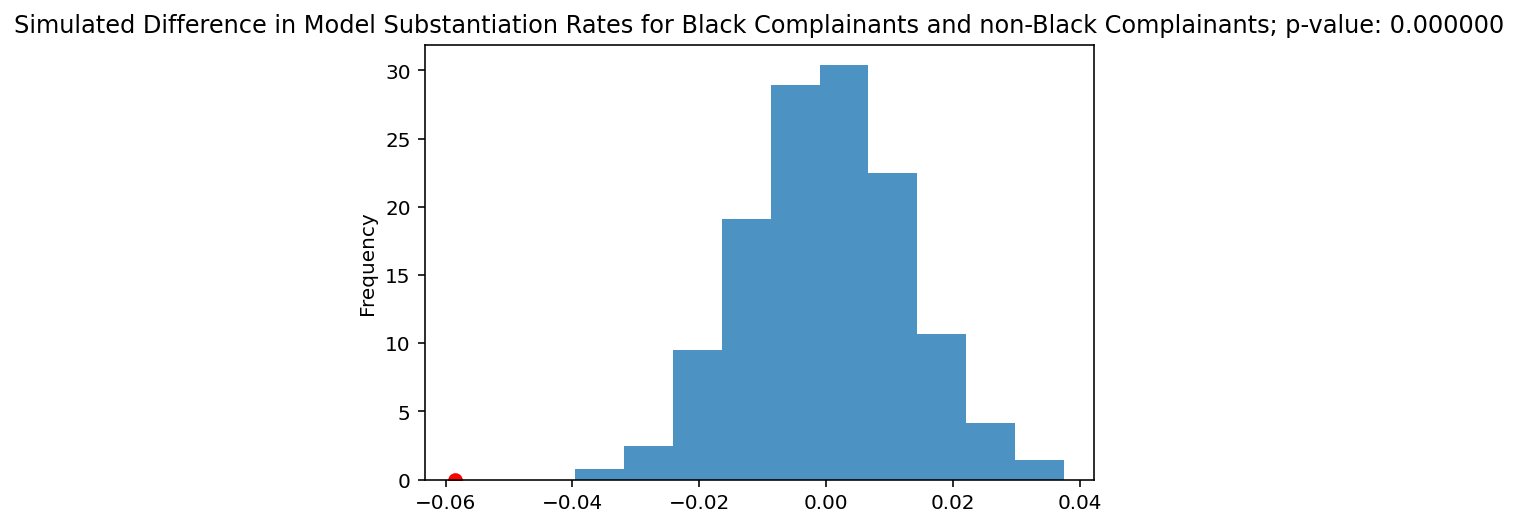

In [431]:
title = 'Simulated Difference in Model Substantiation Rates for Black Complainants and non-Black Complainants'
title += '; p-value: %f' % p_value_eth
(pd.Series(test_statistics_eth)).plot(kind='hist', density=True, alpha=0.8, title=title)
plt.scatter(observed, 0, color='red', s=40)
plt.show()

## Equality of Odds
With the original dataset analyzed in Paper 1, there was no attribute reflecting the ground truth, which was stated to be whether the CCRB correctly deemed a complaint as (un)substantiated. While the ground truth is still unobservable, we can use the actual CCRB disposition as a *proxy* for Y (the true binary label). Using the CCRB's decision as a proxy, we can calculate false positive and true positive rates, meaning we can calculate equality of odds. Furthermore, if we assume that the proxy for true label (whether the CCRB substantiates a given complaint) reflects a complainant's effort-based utility (i.e., a complaint that should be substantiated is actually substantiated by the CCRB), then Fair Equality of Opportunity translates to equality of odds. As discussed in Paper 1, assuming that no particular group is more likely to submit a false complaint, all complainants across groups are equally qualified for substantiation. So, since we expect Fair Equality of Opportunity to hold, we would also expect the model to satisfy Equality of Odds.

$$P(C=1 | Y=1, \text{complainant ethnicity = Black}) = P(C=1 | Y=1, \text{complainant ethnicity} \neq \text{Black})$$
$$\text{and}$$
$$P(C=1 | Y=0, \text{complainant ethnicity = Black}) = P(C=1 | Y=0, \text{complainant ethnicity} \neq \text{Black})$$

The true positive rate for Black complainants is about 7% lower than that for non-Black complainants, meaning that the model missed about 7% more substantiated complaints for Black complainants. The false positive rate for Black complainants is about 5% lower than for non-Black complainants. The model gave more complaints submitted by non-Black complainants the “benefit of the doubt” and classified more CCRB-unsubstantiated complaints as substantiated than for Black complainants. This violation of equality of odds is verified via permutation test in which the differences in TPR and FPR both yielded significant p-values.

In [57]:
model_results['substantiated'] = model_df.substantiated

In [778]:
sub_black = model_results.loc[(model_results.substantiated == True) & (model_results.black==True)]
sub_black_tp = sub_black.loc[(sub_black.classification==1)]
tpr_black = sub_black_tp.shape[0] / sub_black.shape[0]
sub_nb = model_results.loc[(model_results.substantiated == True) & (model_results.black!=True)]
sub_nb_tp = sub_nb.loc[(sub_nb.classification==1)]
tpr_nb = sub_nb_tp.shape[0] / sub_nb.shape[0]

In [779]:
print("Observed Difference in True Positive Rate for Black complainants vs. non-Black complainants: {}".format(tpr_black - tpr_nb))

Observed Difference in True Positive Rate for Black complainants vs. non-Black complainants: -0.067703495872033


In [780]:
unsub_black = model_results.loc[(model_results.substantiated == False) & (model_results.black==True)]
sub_black_fp = unsub_black.loc[(unsub_black.classification==1)]
fpr_black = sub_black_fp.shape[0] / unsub_black.shape[0]
unsub_nb = model_results.loc[(model_results.substantiated == False) & (model_results.black!=True)]
sub_nb_fp = unsub_nb.loc[(unsub_nb.classification==1)]
fpr_nb = sub_nb_fp.shape[0] / unsub_nb.shape[0]

In [781]:
print("Observed Difference in False Positive Rate for Black complainants vs. non-Black complainants: {}".format(fpr_black - fpr_nb))

Observed Difference in False Positive Rate for Black complainants vs. non-Black complainants: -0.047373009440781544


In [62]:
def permutation_test_eo(df, observed_tp, observed_fp, n_repetitions):
    fpr_diffs = []
    tpr_diffs = []
    for _ in range(n_repetitions):
        # shuffle the statistic of interest
        shuffled_values = (df['black'].sample(replace=False, frac=1)
            .reset_index(drop=True))
        # put them in a table
        shuffled = df.copy().reset_index()
        shuffled['Shuffled Values'] = shuffled_values
        shuffled_black = shuffled.loc[shuffled['Shuffled Values'] == True]
        shuffled_nb = shuffled.loc[shuffled['Shuffled Values'] != True]
        # compute the group differences (test statistic!)
        denom_black_tpr = (shuffled_black.substantiated==1).sum()
        # tp: true is 1 and classified 1
        num_black_tpr = (shuffled_black.loc[(shuffled_black.substantiated==1) & (shuffled_black.classification==1)]).shape[0]

        # fp + tn: originally 0
        denom_black_fpr = (shuffled_black.substantiated==0).sum()
        # fp: originally 0 but classified 1
        num_black_fpr = (shuffled_black.loc[(shuffled_black.substantiated==0) & (shuffled_black.classification==1)]).shape[0]

        black_tpr = num_black_tpr/denom_black_tpr
        black_fpr = num_black_fpr/denom_black_fpr

        denom_nb_tpr = (shuffled_nb.substantiated==1).sum()
        num_nb_tpr = (shuffled_nb.loc[(shuffled_nb.substantiated==1) & (shuffled_nb.classification==1)]).shape[0]

        # fp + tn
        denom_nb_fpr = (shuffled_nb.substantiated==0).sum()
        # fp
        num_nb_fpr = (shuffled_nb.loc[(shuffled_nb.substantiated==0) & (shuffled_nb.classification==1)]).shape[0]

        nb_tpr = num_nb_tpr/denom_nb_tpr
        nb_fpr = num_nb_fpr/denom_nb_fpr
        # add it to the list of results
        fpr_diffs.append(black_fpr - nb_fpr)
        tpr_diffs.append(black_tpr - nb_tpr)
    # p-value to see if got any thing even smaller than observed
    p_value_neg_fpr = np.count_nonzero(np.array(fpr_diffs) < min([observed_fp, observed_fp*-1])) / n_repetitions
    # p-value to see if got any thing even bigger than observed
    p_value_pos_fpr = np.count_nonzero(np.array(fpr_diffs) > max([observed_fp, observed_fp*-1])) / n_repetitions
    p_value_fpr = p_value_neg_fpr + p_value_pos_fpr
    # p-value to see if got any thing even smaller than observed
    p_value_neg_tpr = np.count_nonzero(np.array(tpr_diffs) < min([observed_tp, observed_tp*-1])) / n_repetitions
    # p-value to see if got any thing even bigger than observed
    p_value_pos_tpr = np.count_nonzero(np.array(tpr_diffs) > max([observed_tp, observed_tp*-1])) / n_repetitions
    p_value_tpr = p_value_neg_tpr + p_value_pos_tpr
    return (fpr_diffs, p_value_fpr, tpr_diffs, p_value_tpr)

In [63]:
test_statistics_fpr, p_value_fpr, test_statistics_tpr, p_value_tpr = permutation_test_eo(model_results, tpr_black - tpr_nb, fpr_black - fpr_nb, 1000)

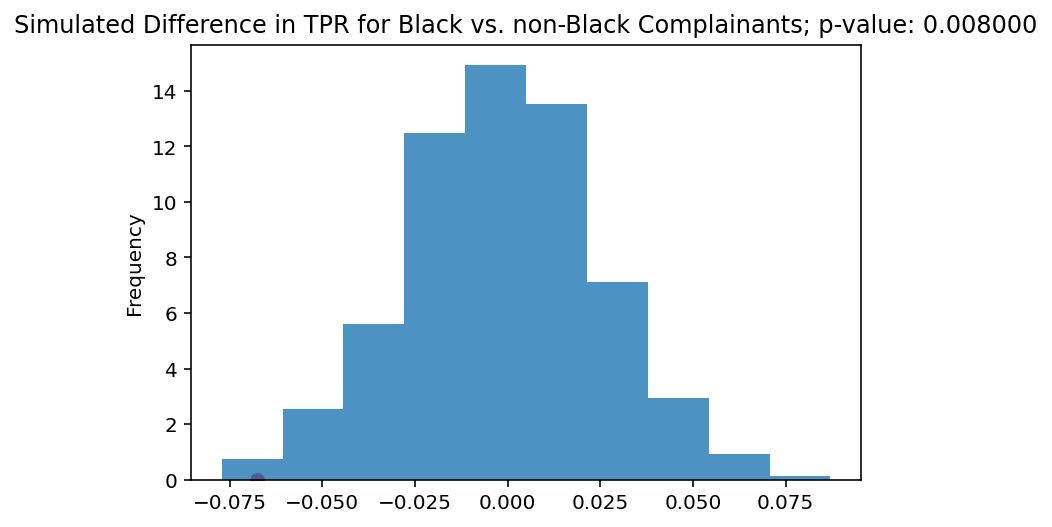

In [64]:
title = 'Simulated Difference in TPR for Black vs. non-Black Complainants'
title += '; p-value: %f' % p_value_tpr
(pd.Series(test_statistics_tpr)).plot(kind='hist', density=True, alpha=0.8, title=title)
plt.scatter(tpr_black - tpr_nb, 0, color='red', s=40)
plt.show()

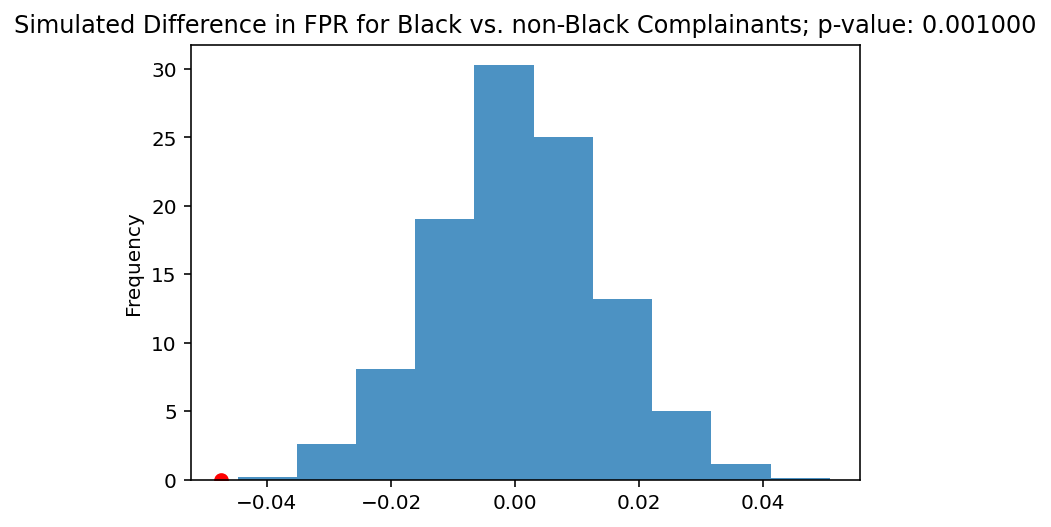

In [65]:
title = 'Simulated Difference in FPR for Black vs. non-Black Complainants'
title += '; p-value: %f' % p_value_fpr
(pd.Series(test_statistics_fpr)).plot(kind='hist', density=True, alpha=0.8, title=title)
plt.scatter(fpr_black - fpr_nb, 0, color='red', s=40)
plt.show()

## Predictive Value Parity

This parity measure requries that the true substantiation rates are the same across groups (or circumstances). Since we assume that complainant ethnicity (S) and the model (C) are not independent of the CCRB's decision (Y), then predictive value parity cannot hold if demographic parity or equality of odds hold. But, since neither of those parity metrics hold, we might expect PPV-Parity and NPV-Parity to hold. Satisfying predictive value parity would translate to luck egalitarianism if we assume effort-based utility is equal to the model prediction (i.e., a complaint that should get substantiated is substantiated by the model) and actual utility (what the model classifies) is the same as what the CCRB rules. Since the ground truth is unobservable, the CCRB's decision is again used as a *proxy*; Y in this case represents a proxy for the ground truth, not the actual ground truth.

PPV-Parity: $P(Y = 1 | C = 1, \text{complainant ethnicity} = \text{Black}) = P(Y = 1 | C = 1, \text{complainant ethnicity} \neq \text{Black})$.
The observed difference between positive predictive value for Black complainants vs. non-Black complainants is about -0.038. While this isn't 0, a permutation test with a significance level of 0.05 yields a p-value of 0.051, indicating that this difference in PPV is not significantly different from 0. Thus, PPV-parity is satisfied. 

In [782]:
c1_black = model_results.loc[(model_results.classification == 1) & (model_results.black==True)]
sub_black = c1_black.loc[(c1_black.substantiated==True)]
ppv_black = sub_black.shape[0] / c1_black.shape[0]
c1_nb = model_results.loc[(model_results.classification == 1) & (model_results.black!=True)]
sub_nb = c1_nb.loc[(c1_nb.substantiated==True)]
ppv_nb = sub_nb.shape[0] / c1_nb.shape[0]

In [783]:
print("Observed Difference in Positive Predictive Value for Black complainants vs. non-Black complainants: {}".format(ppv_black - ppv_nb))

Observed Difference in Positive Predictive Value for Black complainants vs. non-Black complainants: -0.03807527097779484


In [68]:
def permutation_test_ppv(df, observed, n_repetitions):
    test_statistics = []
    for _ in range(n_repetitions):
        # shuffle the statistic of interest
        shuffled_values = (df['black'].sample(replace=False, frac=1)
            .reset_index(drop=True))
        # put them in a table
        shuffled = df.copy().reset_index()
        shuffled['Shuffled Values'] = shuffled_values
        c1_black = shuffled.loc[(shuffled.classification == 1) & (shuffled['Shuffled Values']==True)]
        sub_black = c1_black.loc[(c1_black.substantiated==True)]
        ppv_black = sub_black.shape[0] / c1_black.shape[0]
        c1_nb = shuffled.loc[(shuffled.classification == 1) & (shuffled['Shuffled Values']!=True)]
        sub_nb = c1_nb.loc[(c1_nb.substantiated==True)]
        ppv_nb = sub_nb.shape[0] / c1_nb.shape[0]
        difference = ppv_black - ppv_nb
        test_statistics.append(difference)
    
    # p-value to see if got any thing even smaller than observed
    p_value_neg = np.count_nonzero(np.array(test_statistics) < min([observed, observed*-1])) / n_repetitions
    # p-value to see if got any thing even bigger than observed
    p_value_pos = np.count_nonzero(np.array(test_statistics) > max([observed, observed*-1])) / n_repetitions
    p_value = p_value_neg + p_value_pos
    return (test_statistics, p_value)

In [69]:
test_stats_ppv_eth, p_value_ppv_eth = permutation_test_ppv(model_results, ppv_black - ppv_nb, 1000 )

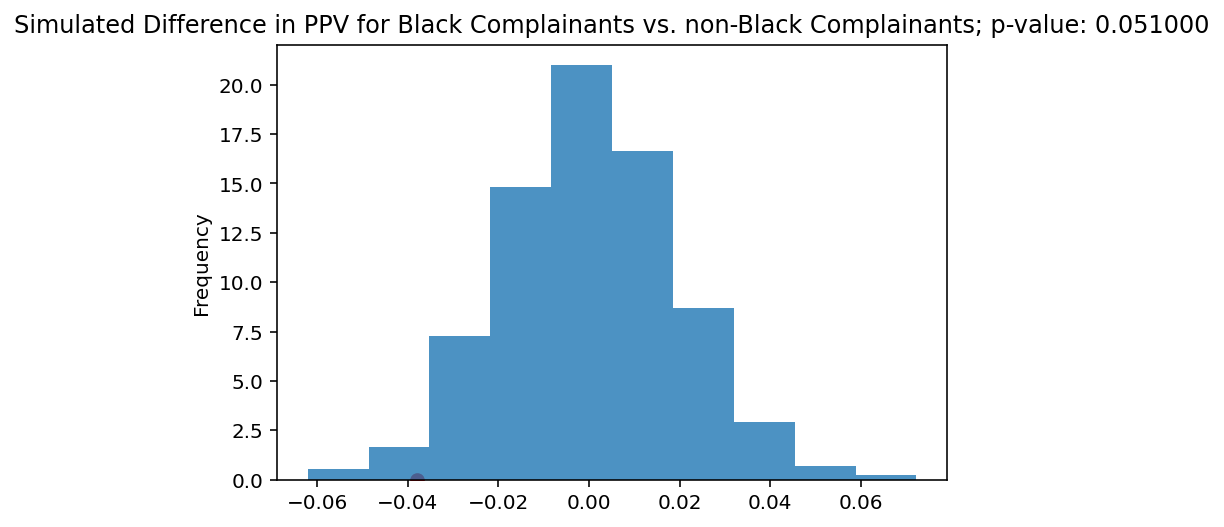

In [70]:
title = 'Simulated Difference in PPV for Black Complainants vs. non-Black Complainants'
title += '; p-value: %f' % p_value_ppv_eth
(pd.Series(test_stats_ppv_eth)).plot(kind='hist', density=True, alpha=0.8, title=title)
plt.scatter(ppv_black - ppv_nb, 0, color='red', s=40)
plt.show()

NPV-Parity: $P(Y = 0 | C = 0, \text{complainant ethnicity} = \text{Black}) = P(Y = 0 | C = 0, \text{complainant ethnicity} \neq \text{Black})$

The negative predictive value parity for Black complainants is about 0.016 higher than that for non-Black complainants. A permutiation test with significance level of 0.05 yielded a p-value of 0.198, meaning this difference is not statistically different from 0. Thus NPV-parity is satisfied.

Since both PPV-parity and NPV-parity between Black and non-Black complainants are satisfied, predictive value parity is satisfied. This means that the model does an equally "good" job of ensuring complaints that should be substantiated (as determined by the proxy - CCRB's original decision) are correctly classified and that complaints that should be unsubstantiated are predicted the negative class. Since demographic parity and equalized odds parity cannot simulataneously hold (assuming the proxy for the ground truth Y, the CCRB's decision, is dependent on complainant ethnicity and the model C), it makes sense that predictive value parity does.

In [784]:
c0_black = model_results.loc[(model_results.classification == 0) & (model_results.black==True)]
unsub_black = c0_black.loc[(c0_black.substantiated==False)]
npv_black = unsub_black.shape[0] / c0_black.shape[0]
c0_nb = model_results.loc[(model_results.classification == 0) & (model_results.black!=True)]
unsub_nb = c0_nb.loc[(c0_nb.substantiated==False)]
npv_nb = unsub_nb.shape[0] / c0_nb.shape[0]

In [785]:
print("Observed Difference in Negative Predictive Value for Black complainants vs. non-Black complainants: {}".format(npv_black - npv_nb))

Observed Difference in Negative Predictive Value for Black complainants vs. non-Black complainants: 0.016560159417302267


In [73]:
def permutation_test_npv(df, observed, n_repetitions):
    test_statistics = []
    for _ in range(n_repetitions):
        # shuffle the statistic of interest
        shuffled_values = (df['black'].sample(replace=False, frac=1)
            .reset_index(drop=True))
        # put them in a table
        shuffled = df.copy().reset_index()
        shuffled['Shuffled Values'] = shuffled_values
        c0_black = shuffled.loc[(shuffled.classification == 0) & (shuffled['Shuffled Values']==True)]
        unsub_black = c0_black.loc[(c0_black.substantiated==False)]
        npv_black = unsub_black.shape[0] / c0_black.shape[0]
        c0_nb = shuffled.loc[(shuffled.classification == 0) & (shuffled['Shuffled Values']!=True)]
        unsub_nb = c0_nb.loc[(c0_nb.substantiated==False)]
        npv_nb = unsub_nb.shape[0] / c0_nb.shape[0]
        difference = npv_black - npv_nb
        test_statistics.append(difference)
        # difference in means:
    # p-value to see if got any thing even smaller than observed
    p_value_neg = np.count_nonzero(np.array(test_statistics) < min([observed, observed*-1])) / n_repetitions
    # p-value to see if got any thing even bigger than observed
    p_value_pos = np.count_nonzero(np.array(test_statistics) > max([observed, observed*-1])) / n_repetitions
    p_value = p_value_neg + p_value_pos
    return (test_statistics, p_value)

In [74]:
test_stats_npv_eth, p_value_npv_eth = permutation_test_npv(model_results, npv_black - npv_nb, 1000 )

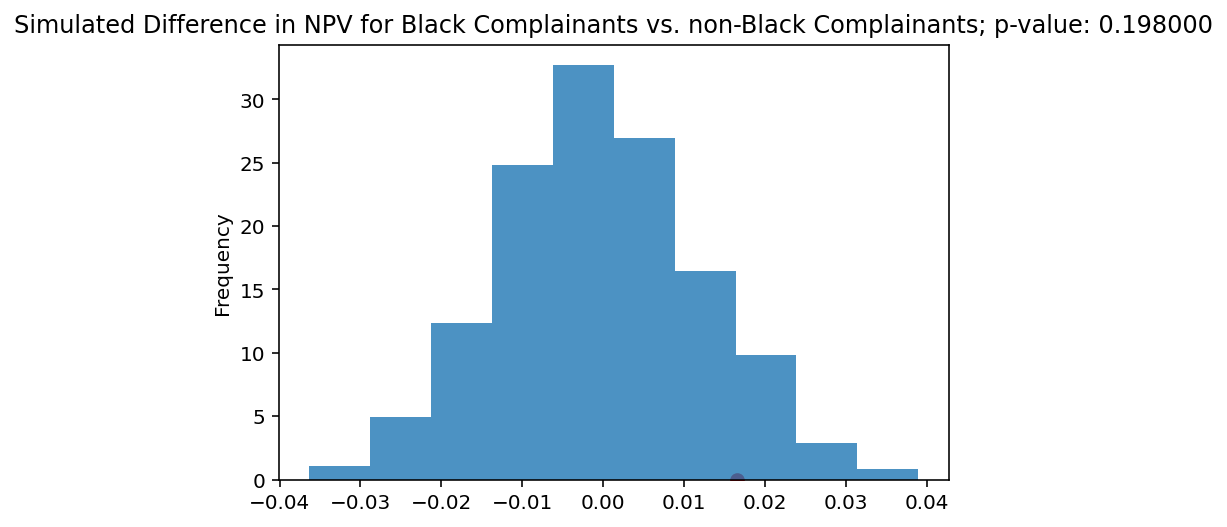

In [75]:
title = 'Simulated Difference in NPV for Black Complainants vs. non-Black Complainants'
title += '; p-value: %f' % p_value_npv_eth
(pd.Series(test_stats_npv_eth)).plot(kind='hist', density=True, alpha=0.8, title=title)
plt.scatter(npv_black - npv_nb, 0, color='red', s=40)
plt.show()

# Threshold Tests

## Group Aware Thresholds For Maximizing Utility

When creating the original model, the entire dataset was used to determine an optimal threshold. Alternatively, using the same logic, we can find the optimal threshold for a given *group* by simply providing only the samples within that group. The same function/methodology of maximizing utility and the same weight of 0.4 will be used to find the group-wise best thresholds. Once the group-wise best thresholds are found with the training data, the parity measures can be recalculated on the test data to see if the new thresholds yield any changes or improvements. 

In [76]:
print('Overall Best Threshold: {}'.format(best_threshold))

Overall Best Threshold: 0.527


For Black complainants, the best threshold is 0.522, corresponding to a false positive rate of about 0.32 and a true positive rate of 0.56. The best threshold for non-Black complainants is 0.546, associated with a FPR of 0.32 and TPR of 0.52. At these groupwise thresholds, the model performs fairly similar, with the model performing a bit better for Black complainants with the higher true positive rate and fairly similar false positive rate. 

In [787]:
best_threshold_black, utility_black = find_best_thresh(df.loc[df.black==True],0.4)
print('Best Threshold for Black Complainants: {}'.format(round(best_threshold_black,3)))

Best Threshold for Black Complainants: 0.522


In [788]:
best_threshold_nb, utility_nb = find_best_thresh(df.loc[df.black!=True],0.4)
print('Best Threshold for non-Black Complainants: {}'.format(round(best_threshold_nb,3)))

Best Threshold for non-Black Complainants: 0.546


In [145]:
model_results_training_black = model_results_training.loc[model_results_training.black == True]
fpr_black, tpr_black, thresholds_black = metrics.roc_curve(model_results_training_black.ccrb,model_results_training_black.proba)
best_index_black = list(thresholds_black).index(list(filter(lambda x: np.isclose(x, best_threshold_black, atol=0.0001), sorted(thresholds_black,reverse=True)))[0])

model_results_training_nb = model_results_training.loc[model_results_training.black == False]
fpr_nb, tpr_nb, thresholds_nb = metrics.roc_curve(model_results_training_nb.ccrb,model_results_training_nb.proba)
best_index_nb = list(thresholds_nb).index(list(filter(lambda x: np.isclose(x, best_threshold_nb, atol=0.0001), sorted(thresholds_nb,reverse=True)))[0])

In [84]:
from sklearn.metrics import plot_roc_curve

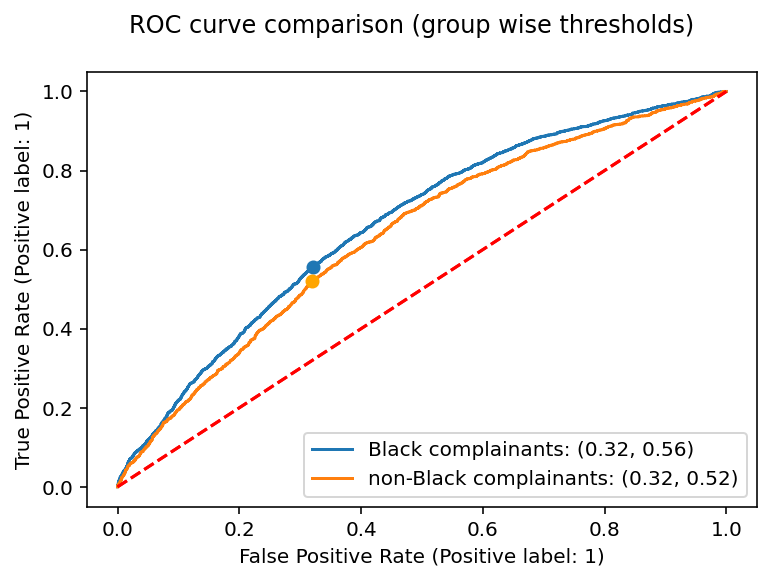

In [148]:
fig = plot_roc_curve( pl, model_results_training_black.drop(columns=['ccrb','proba']), model_results_training_black.ccrb)
fig = plot_roc_curve( pl, model_results_training_nb.drop(columns=['ccrb','proba']), model_results_training_nb.ccrb, ax = fig.ax_)
fig.figure_.suptitle("ROC curve comparison (group wise thresholds)")
plt.plot([fpr_black[best_index_black]], [tpr_black[best_index_black]], 'ro', color = 'tab:blue')
plt.plot([fpr_nb[best_index_nb]], [tpr_nb[best_index_nb]], 'ro', color = 'orange')
plt.legend(['Black complainants: ({}, {})'.format(round(fpr_black[best_index_black],2),round(tpr_black[best_index_black],2)),
            'non-Black complainants: ({}, {})'.format(round(fpr_nb[best_index_nb],2),round(tpr_nb[best_index_nb],2))])
plt.plot([(0,0), (1,1)], 'r--')
plt.show()

In [89]:
best_og_index_black = list(thresholds_black).index(list(filter(lambda x: np.isclose(x, best_threshold, atol=0.0001), sorted(thresholds_black,reverse=True)))[0])
best_og_index_nb = list(thresholds_nb).index(list(filter(lambda x: np.isclose(x, best_threshold, atol=0.0001), sorted(thresholds_nb,reverse=True)))[0])

When comparing this to how the performance overall best threshold (0.527), the false positive rate for Black complainants is a bit lower, but the true positive rate is also lower. For non-Black complainants, both the false positive and true positive rates increased. Additionally, the FPR and TPR of each group under the single threshold are further apart. It seems that choosing a threshold for each group made the model perform more similarly per group.

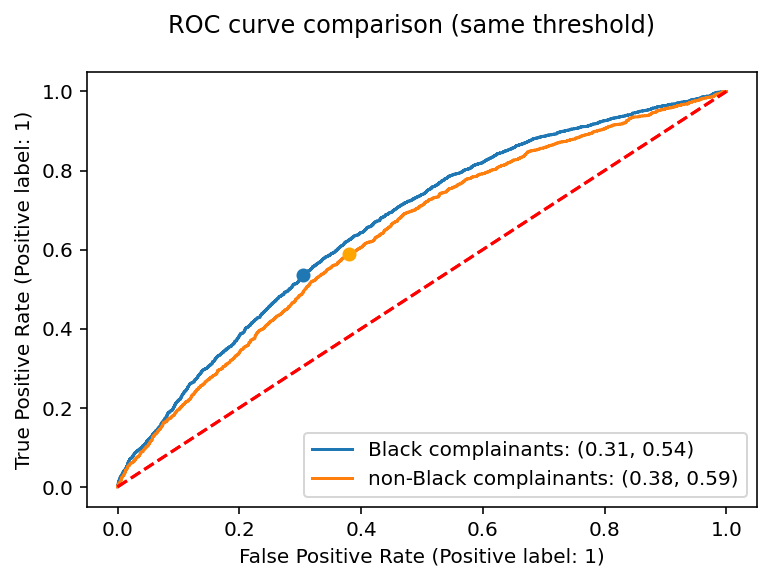

In [92]:
fig = plot_roc_curve( pl, model_results_training_black.drop(columns=['ccrb','proba']), model_results_training_black.ccrb)
fig = plot_roc_curve( pl, model_results_training_nb.drop(columns=['ccrb','proba']), model_results_training_nb.ccrb, ax = fig.ax_)
fig.figure_.suptitle("ROC curve comparison (same threshold)")
plt.plot([fpr_black[best_og_index_black]], [tpr_black[best_og_index_black]], 'ro', color = 'tab:blue')
plt.plot([fpr_nb[best_og_index_nb]], [tpr_nb[best_og_index_nb]], 'ro', color = 'orange')
plt.legend(['Black complainants: ({}, {})'.format(round(fpr_black[best_og_index_black],2),round(tpr_black[best_og_index_black],2)),
            'non-Black complainants: ({}, {})'.format(round(fpr_nb[best_og_index_nb],2),round(tpr_nb[best_og_index_nb],2))])
plt.plot([(0,0), (1,1)], 'r--')
plt.show()

### Demographic Parity

The group wise thresholds that maximize utility also happen to satsify demographic parity. With an observed difference in substantiation rate between Black and non-Black complainants of +0.015 and a permutation test revealing this difference to not be significantly different from 0, the thresholds of 0.522 for Black complainants and 0.54 for non-Black complainants satisfy demographic parity. When compared to the single threshold results, the group wise thresholds substantiate a bit more complaints from Black civilians and a bit less complainants from non-Black civilians.

In [93]:
def group_wise(row):
    eth = row.black
    if eth:
        return row.probability >= best_threshold_black
    else:
        return row.probability >= best_threshold_nb

In [94]:
model_results['classification_gw'] = model_results.apply(group_wise, axis=1)

In [95]:
# pivot table showing number of complaints of each disposition for black and nonblack complainants
nb_sub = model_results.pivot_table(index='black', 
                        columns='classification_gw', aggfunc='size',fill_value=0)
sums = nb_sub.sum(axis=1)
# calculate the proportions of complaints submitted by black and nonblack complainants
# that got substantiated
nb_sub['Substantiated'] =  nb_sub[1] / sums
nb_sub['Not Substantiated'] =  nb_sub[0] / sums
# proportion of all complaints filed by black complainants and nonblack complainants 
prop_black_comp = model_results.loc[model_results['black']].shape[0]/model_results.shape[0]
print('Model Substantiation Rates for Black Complainants vs. non-Black Complainants')
nb_sub['Overall Proportion'] = [1-prop_black_comp, prop_black_comp]
nb_sub[['Substantiated', 'Overall Proportion']]

Model Substantiation Rates for Black Complainants vs. non-Black Complainants


classification_gw,Substantiated,Overall Proportion
black,,
False,0.370600,0.365965
True,0.385516,0.634035


In [96]:
observed = nb_sub['Substantiated'][True]-nb_sub['Substantiated'][False]
print('Observed Difference in Model Substantiation Rate for Black vs. non-Black Complainants: {}'.format(observed))

Observed Difference in Model Substantiation Rate for Black vs. non-Black Complainants: 0.014915838311382434


In [97]:
def permutation_test(df, observed, n_repetitions):
    test_statistics = []
    for _ in range(n_repetitions):
        # shuffle the statistic of interest
        shuffled_values = (df['black'].sample(replace=False, frac=1)
            .reset_index(drop=True))
        # put them in a table
        shuffled = df.copy().reset_index()
        shuffled['Shuffled Values'] = shuffled_values
        # compute the group differences (test statistic!)
        # difference in means:
        nb_disposition = shuffled.pivot_table(index='Shuffled Values', 
                            columns='classification_gw', aggfunc='size',fill_value=0)
        sums = nb_disposition.sum(axis=1)
        nb_disposition['Substantiated'] =  nb_disposition[1] / sums
        difference = nb_disposition['Substantiated'][1]-nb_disposition['Substantiated'][0]
        # add it to the list of results
        test_statistics.append(difference)
    # p-value to see if got any thing even smaller than observed
    p_value_neg = np.count_nonzero(np.array(test_statistics) < min([observed, observed*-1])) / n_repetitions
    # p-value to see if got any thing even bigger than observed
    p_value_pos = np.count_nonzero(np.array(test_statistics) > max([observed, observed*-1])) / n_repetitions
    p_value = p_value_neg + p_value_pos
    return (test_statistics, p_value)

In [98]:
test_statistics_eth, p_value_eth = permutation_test(model_results, observed, 1000)

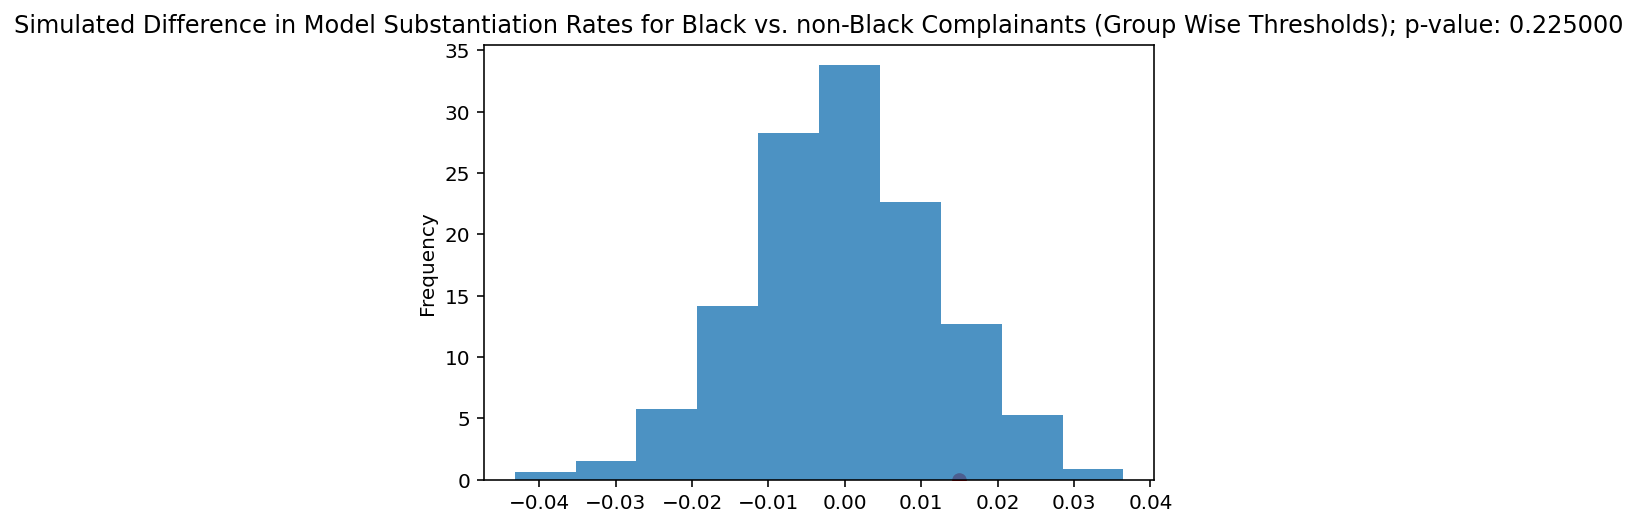

In [99]:
title = 'Simulated Difference in Model Substantiation Rates for Black vs. non-Black Complainants (Group Wise Thresholds)'
title += '; p-value: %f' % p_value_eth
(pd.Series(test_statistics_eth)).plot(kind='hist', density=True, alpha=0.8, title=title)
plt.scatter(observed, 0, color='red', s=40)
plt.show()

### Equality of Odds

Additionally, the group wise thresholds that maximize utility also satisfy equality of odds. The observed difference in true positive parity between Black and non-Black complainants is +0.02, and the difference in false positive parity is -0.047. With the permutation test yielding high p-values for both true positive and false positive parity, equality of odds is satisfied.

In [873]:
sub_black = model_results.loc[(model_results.substantiated == True) & (model_results.black==True)]
sub_black_tp = sub_black.loc[(sub_black.classification_gw==1)]
tpr_black = sub_black_tp.shape[0] / sub_black.shape[0]
sub_nb = model_results.loc[(model_results.substantiated == True) & (model_results.black!=True)]
sub_nb_tp = sub_nb.loc[(sub_nb.classification_gw==1)]
tpr_nb = sub_nb_tp.shape[0] / sub_nb.shape[0]

In [874]:
print("Observed Difference in True Positive Rate for Black complainants vs. non-Black complainants: {}".format(tpr_black - tpr_nb))

Observed Difference in True Positive Rate for Black complainants vs. non-Black complainants: 0.023248839009287925


In [102]:
unsub_black = model_results.loc[(model_results.substantiated == False) & (model_results.black==True)]
sub_black_fp = unsub_black.loc[(unsub_black.classification_gw==1)]
fpr_black = sub_black_fp.shape[0] / unsub_black.shape[0]
unsub_nb = model_results.loc[(model_results.substantiated == False) & (model_results.black!=True)]
sub_nb_fp = unsub_nb.loc[(unsub_nb.classification_gw==1)]
fpr_nb = sub_nb_fp.shape[0] / unsub_nb.shape[0]

In [791]:
print("Observed Difference in False Positive Rate for Black complainants vs. non-Black complainants: {}".format(fpr_black - fpr_nb))

Observed Difference in False Positive Rate for Black complainants vs. non-Black complainants: -0.047373009440781544


In [104]:
def permutation_test_eo(df, observed_tp, observed_fp, n_repetitions):
    fpr_diffs = []
    tpr_diffs = []
    for _ in range(n_repetitions):
        # shuffle the statistic of interest
        shuffled_values = (df['black'].sample(replace=False, frac=1)
            .reset_index(drop=True))
        # put them in a table
        shuffled = df.copy().reset_index()
        shuffled['Shuffled Values'] = shuffled_values
        shuffled_black = shuffled.loc[shuffled['Shuffled Values'] == True]
        shuffled_nb = shuffled.loc[shuffled['Shuffled Values'] != True]
        # compute the group differences (test statistic!)
        denom_black_tpr = (shuffled_black.substantiated==1).sum()
        # tp: true is 1 and classified 1
        num_black_tpr = (shuffled_black.loc[(shuffled_black.substantiated==1) & (shuffled_black.classification_gw==1)]).shape[0]

        # fp + tn: originally 0
        denom_black_fpr = (shuffled_black.substantiated==0).sum()
        # fp: originally 0 but classified 1
        num_black_fpr = (shuffled_black.loc[(shuffled_black.substantiated==0) & (shuffled_black.classification_gw==1)]).shape[0]

        black_tpr = num_black_tpr/denom_black_tpr
        black_fpr = num_black_fpr/denom_black_fpr

        denom_nb_tpr = (shuffled_nb.substantiated==1).sum()
        num_nb_tpr = (shuffled_nb.loc[(shuffled_nb.substantiated==1) & (shuffled_nb.classification_gw==1)]).shape[0]

        # fp + tn
        denom_nb_fpr = (shuffled_nb.substantiated==0).sum()
        # fp
        num_nb_fpr = (shuffled_nb.loc[(shuffled_nb.substantiated==0) & (shuffled_nb.classification_gw==1)]).shape[0]

        nb_tpr = num_nb_tpr/denom_nb_tpr
        nb_fpr = num_nb_fpr/denom_nb_fpr
        # add it to the list of results
        fpr_diffs.append(black_fpr - nb_fpr)
        tpr_diffs.append(black_tpr - nb_tpr)
    # p-value to see if got any thing even smaller than observed
    p_value_neg_fpr = np.count_nonzero(np.array(fpr_diffs) < min([observed_fp, observed_fp*-1])) / n_repetitions
    # p-value to see if got any thing even bigger than observed
    p_value_pos_fpr = np.count_nonzero(np.array(fpr_diffs) > max([observed_fp, observed_fp*-1])) / n_repetitions
    p_value_fpr = p_value_neg_fpr + p_value_pos_fpr
    # p-value to see if got any thing even smaller than observed
    p_value_neg_tpr = np.count_nonzero(np.array(tpr_diffs) < min([observed_tp, observed_tp*-1])) / n_repetitions
    # p-value to see if got any thing even bigger than observed
    p_value_pos_tpr = np.count_nonzero(np.array(tpr_diffs) > max([observed_tp, observed_tp*-1])) / n_repetitions
    p_value_tpr = p_value_neg_tpr + p_value_pos_tpr
    return (fpr_diffs, p_value_fpr, tpr_diffs, p_value_tpr)

In [107]:
test_statistics_fpr, p_value_fpr, test_statistics_tpr, p_value_tpr = permutation_test_eo(model_results, tpr_black - tpr_nb, fpr_black - fpr_nb, 1000)

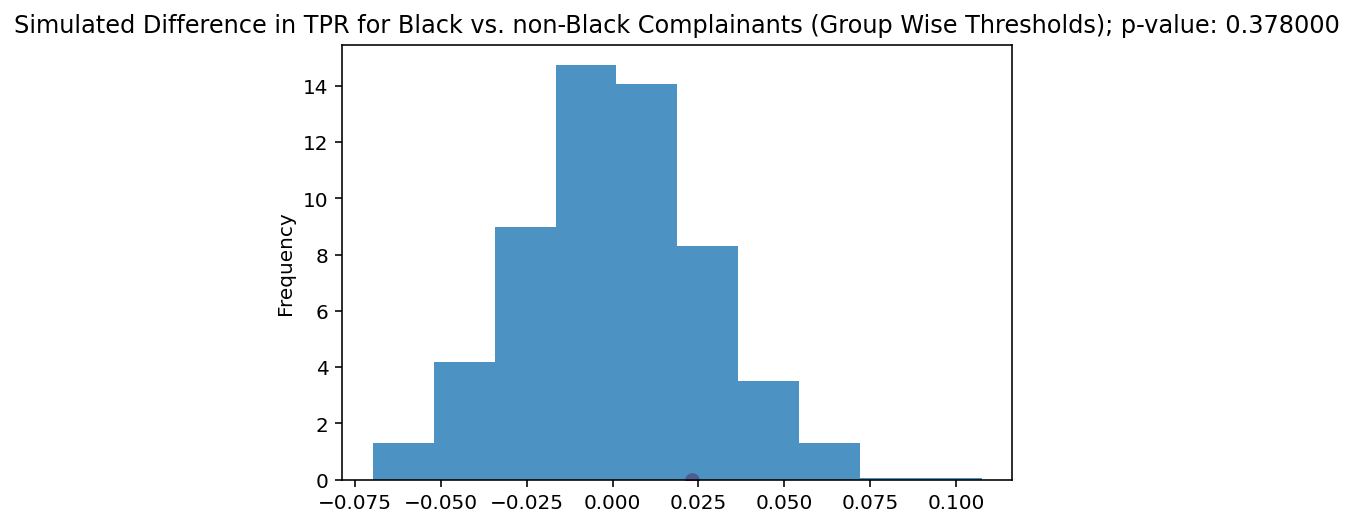

In [108]:
title = 'Simulated Difference in TPR for Black vs. non-Black Complainants (Group Wise Thresholds)'
title += '; p-value: %f' % p_value_tpr
(pd.Series(test_statistics_tpr)).plot(kind='hist', density=True, alpha=0.8, title=title)
plt.scatter(tpr_black - tpr_nb, 0, color='red', s=40)
plt.show()

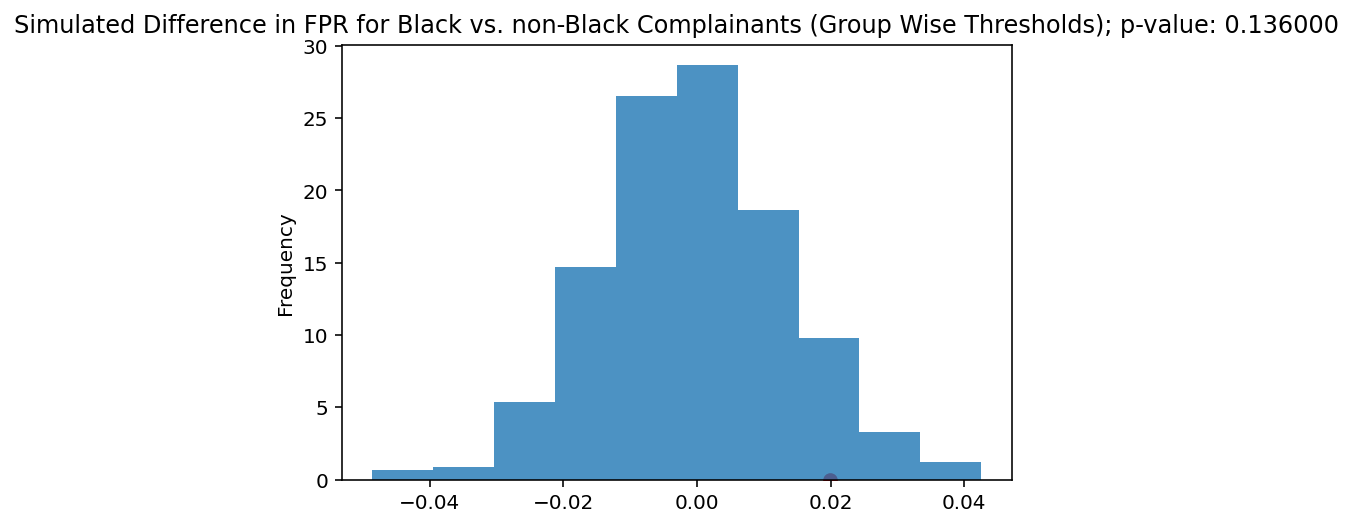

In [109]:
title = 'Simulated Difference in FPR for Black vs. non-Black Complainants (Group Wise Thresholds)'
title += '; p-value: %f' % p_value_fpr
(pd.Series(test_statistics_fpr)).plot(kind='hist', density=True, alpha=0.8, title=title)
plt.scatter(fpr_black - fpr_nb, 0, color='red', s=40)
plt.show()

### Predictive Value Parity

With the single threshold of 0.527 that maximizes utility overall, predicitve value parity was already satisfied. Under a significance level of 0.05, the two-sided permuation test yielded p-values smaller than 0.05, meaning the observed differences in positive value parity (-0.035) and negative value parity (0.015) resulting from the group wise thresholds are significantly different from 0. Predictive value parity doesn't hold when thresholds of 0.522 for Black complainants and 0.54 for non-Black complainants are used. This is expected if we assume that complainant ethnicity and the *proxy* (CCRB decision) for the ground truth Y (whether the CCRB is correct) are not independent. 

In [793]:
c1_black = model_results.loc[(model_results.classification_gw == 1) & (model_results.black==True)]
sub_black = c1_black.loc[(c1_black.substantiated==True)]
ppv_black = sub_black.shape[0] / c1_black.shape[0]
c1_nb = model_results.loc[(model_results.classification_gw == 1) & (model_results.black!=True)]
sub_nb = c1_nb.loc[(c1_nb.substantiated==True)]
ppv_nb = sub_nb.shape[0] / c1_nb.shape[0]

In [794]:
print("Observed Difference in Positive Predictive Value for Black complainants vs. non-Black complainants: {}".format(ppv_black - ppv_nb))

Observed Difference in Positive Predictive Value for Black complainants vs. non-Black complainants: -0.04284601024497192


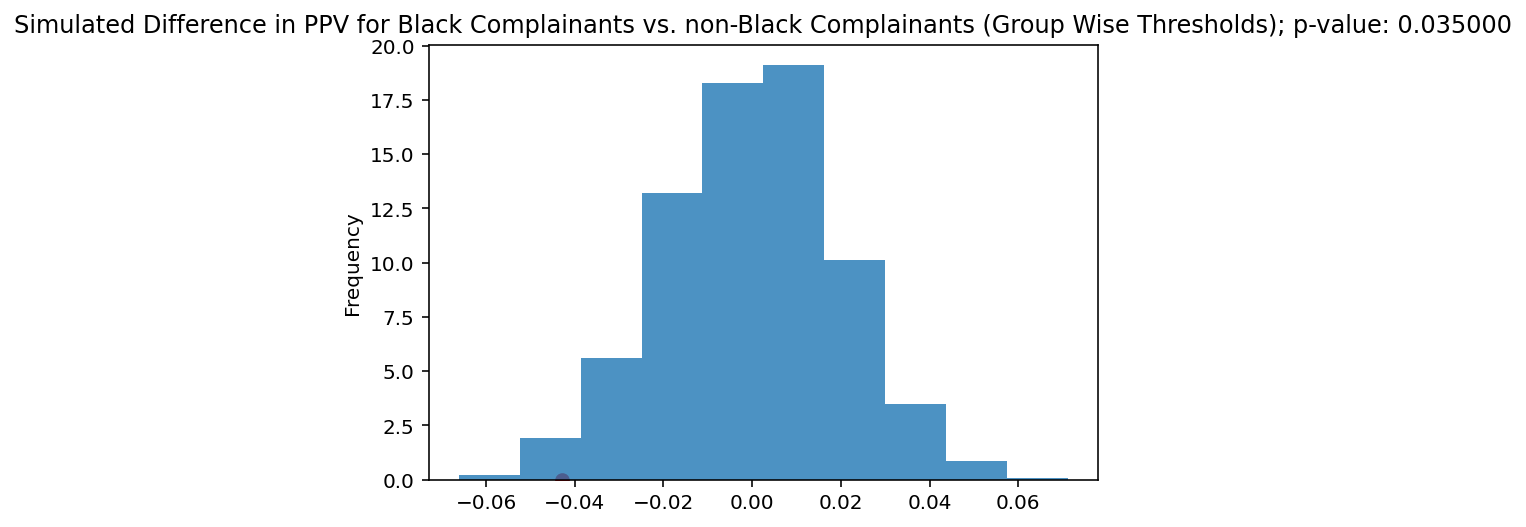

In [112]:
def permutation_test_ppv(df, observed, n_repetitions):
    test_statistics = []
    for _ in range(n_repetitions):
        # shuffle the statistic of interest
        shuffled_values = (df['black'].sample(replace=False, frac=1)
            .reset_index(drop=True))
        # put them in a table
        shuffled = df.copy().reset_index()
        shuffled['Shuffled Values'] = shuffled_values
        c1_black = shuffled.loc[(shuffled.classification_gw == 1) & (shuffled['Shuffled Values']==True)]
        sub_black = c1_black.loc[(c1_black.substantiated==True)]
        ppv_black = sub_black.shape[0] / c1_black.shape[0]
        c1_nb = shuffled.loc[(shuffled.classification_gw == 1) & (shuffled['Shuffled Values']!=True)]
        sub_nb = c1_nb.loc[(c1_nb.substantiated==True)]
        ppv_nb = sub_nb.shape[0] / c1_nb.shape[0]
        difference = (ppv_black - ppv_nb)
        test_statistics.append(difference)
        # difference in means:
    # p-value to see if got any thing even smaller than observed
    p_value_neg = np.count_nonzero(np.array(test_statistics) < min([observed, observed*-1])) / n_repetitions
    # p-value to see if got any thing even bigger than observed
    p_value_pos = np.count_nonzero(np.array(test_statistics) > max([observed, observed*-1])) / n_repetitions
    p_value = p_value_neg + p_value_pos
    return (test_statistics, p_value)
test_stats_ppv_gw, p_value_ppv_gw = permutation_test_ppv(model_results, ppv_black - ppv_nb, 1000 )
title = 'Simulated Difference in PPV for Black Complainants vs. non-Black Complainants (Group Wise Thresholds)'
title += '; p-value: %f' % p_value_ppv_gw
(pd.Series(test_stats_ppv_gw)).plot(kind='hist', density=True, alpha=0.8, title=title)
plt.scatter((ppv_black - ppv_nb), 0, color='red', s=40)
plt.show()

In [795]:
c0_black = model_results.loc[(model_results.classification_gw == 0) & (model_results.black==True)]
unsub_black = c0_black.loc[(c0_black.substantiated==False)]
npv_black = unsub_black.shape[0] / c0_black.shape[0]
c0_nb = model_results.loc[(model_results.classification_gw == 0) & (model_results.black!=True)]
unsub_nb = c0_nb.loc[(c0_nb.substantiated==False)]
npv_nb = unsub_nb.shape[0] / c0_nb.shape[0]

In [796]:
print("Observed Difference in Negative Predictive Value for Black complainants vs. non-Black complainants: {}".format(npv_black - npv_nb))

Observed Difference in Negative Predictive Value for Black complainants vs. non-Black complainants: 0.030978628016950283


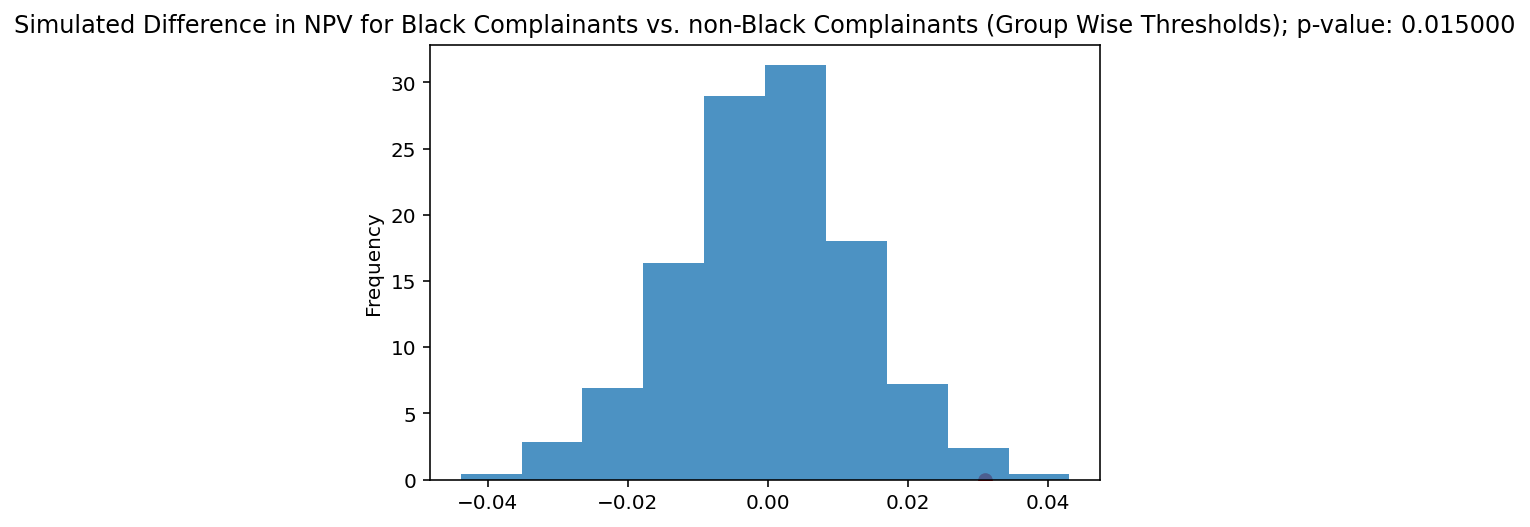

In [115]:
def permutation_test_npv(df, observed, n_repetitions):
    test_statistics = []
    for _ in range(n_repetitions):
        # shuffle the statistic of interest
        shuffled_values = (df['black'].sample(replace=False, frac=1)
            .reset_index(drop=True))
        # put them in a table
        shuffled = df.copy().reset_index()
        shuffled['Shuffled Values'] = shuffled_values
        c0_black = shuffled.loc[(shuffled.classification_gw == 0) & (shuffled['Shuffled Values']==True)]
        unsub_black = c0_black.loc[(c0_black.substantiated==False)]
        npv_black = unsub_black.shape[0] / c0_black.shape[0]
        c0_nb = shuffled.loc[(shuffled.classification_gw == 0) & (shuffled['Shuffled Values']!=True)]
        unsub_nb = c0_nb.loc[(c0_nb.substantiated==False)]
        npv_nb = unsub_nb.shape[0] / c0_nb.shape[0]
        difference = (npv_black - npv_nb)
        test_statistics.append(difference)
        # difference in means:
    # p-value to see if got any thing even smaller than observed
    p_value_neg = np.count_nonzero(np.array(test_statistics) < min([observed, observed*-1])) / n_repetitions
    # p-value to see if got any thing even bigger than observed
    p_value_pos = np.count_nonzero(np.array(test_statistics) > max([observed, observed*-1])) / n_repetitions
    p_value = p_value_neg + p_value_pos
    return (test_statistics, p_value)
test_stats_npv_gw, p_value_npv_gw = permutation_test_npv(model_results, npv_black - npv_nb, 1000 )
title = 'Simulated Difference in NPV for Black Complainants vs. non-Black Complainants (Group Wise Thresholds)'
title += '; p-value: %f' % p_value_npv_gw
(pd.Series(test_stats_npv_gw)).plot(kind='hist', density=True, alpha=0.8, title=title)
plt.scatter(npv_black - npv_nb, 0, color='red', s=40)
plt.show()

## Group Thresholds for Parity

Another way to decide on group-wise thresholds is to find thresholds for each group that satisfy parity. To do so, we'll first use the training set to determine a set of thresholds for which parity holds. Then, using these thresholds and the test data, the parity measures will be recalculated to see if they hold with "real world"/"unseen" data.

### Demographic Parity

Since the dataset is fairly small, the approach was to simply loop through possible threshold combibnations and find the ones for which demographic parity is satisfied. The 2 thresholds for which demographic parity is satisfied (on the training set), ended up being the same thresholds found that maximize utility per group: 0.522 for Black complainants and 0.546 for non-Black complainants. These thresholds already proved to satisfy demographic parity on the test set, so the permuation tests weren't re-performed.

In [116]:
model_results_training_black_proba = model_results_training_black.proba
model_results_training_nb_proba = model_results_training_nb.proba

In [117]:
black_dict = {}
nb_dict = {}
for t in np.arange(0.1, 1.1, 0.01):
    t = round(t,2)
    black_props = (model_results_training_black_proba >= t).value_counts(normalize=True)
    try:
        black_sub = black_props[True]
        black_dict[t] = black_sub
    except KeyError:
        black_dict[t] = 0
    nb_props = (model_results_training_nb_proba >= t).value_counts(normalize=True)
    try:
        nb_sub = nb_props[True]
        nb_dict[t] = nb_sub
    except KeyError:
        nb_dict[t] = 0

In [118]:
results_dp = {}

In [119]:
for k in black_dict:
    curr_black = black_dict[k]
    if curr_black == 0:
        continue
    for knb in nb_dict:
        curr_nb = nb_dict[knb]
        if curr_nb == 0:
            continue
        if np.abs(curr_black - curr_nb) < 0.02:
            key = tuple([k,knb])
            if key in results_dp:
                curr_val = results_dp[key]
                results_dp[key] = np.min([curr_val, curr_black - curr_nb])
            else:
                results_dp[key] = curr_black - curr_nb

In [120]:
utility_results_dp = {}
for k in results_dp:
    black_thresh = k[0]
    nb_thresh = k[1]
    black_utility = calc_utility(df.loc[df.black == True],black_thresh, 0.4)
    nb_utility = calc_utility(df.loc[df.black == False],nb_thresh, 0.4)
    utility_results_dp[k] = (black_utility,nb_utility)

In [121]:
black_utilities = list(map(lambda t: t[0], utility_results_dp.values()))
nb_utilities = list(map(lambda t: t[1], utility_results_dp.values()))

In [122]:
black_threshs = list(map(lambda t: t[0], utility_results_dp.keys()))
nb_threshs = list(map(lambda t: t[1], utility_results_dp.keys()))

In [123]:
utility_df = pd.DataFrame(data = {'black_threshold':black_threshs,'nb_threshold':nb_threshs,'black_utility':black_utilities,'nb_utility':nb_utilities})

In [124]:
best_utilities = utility_df.sort_values(['black_utility','nb_utility'],ascending=False).head(10)
best_utilities['mean_utility'] = (best_utilities.black_utility + best_utilities.nb_utility)/2

In [125]:
black_dict2 = {}
nb_dict2 = {}
for t in np.arange(0.51, 0.561, 0.001):
    black_props = (model_results_training_black_proba >= t).value_counts(normalize=True)
    try:
        black_sub = black_props[True]
        black_dict2[t] = black_sub
    except KeyError:
        black_dict2[t] = 0
    nb_props = (model_results_training_nb_proba >= t).value_counts(normalize=True)
    try:
        nb_sub = nb_props[True]
        nb_dict2[t] = nb_sub
    except KeyError:
        nb_dict2[t] = 0

In [126]:
results_dp2 = {}
for k in black_dict2:
    curr_black = black_dict2[k]
    if curr_black == 0:
        continue
    for knb in nb_dict2:
        curr_nb = nb_dict2[knb]
        if curr_nb == 0:
            continue
        if np.abs(curr_black - curr_nb) < 0.02:
            key = tuple([k,knb])
            if key in results_dp2:
                curr_val = results_dp2[key]
                results_dp2[key] = np.min([curr_val, curr_black - curr_nb])
            else:
                results_dp2[key] = curr_black - curr_nb

In [127]:
utility_results_dp2 = {}
for k in results_dp2:
    black_thresh = k[0]
    nb_thresh = k[1]
    black_utility = calc_utility(df.loc[df.black == True],black_thresh, 0.4)
    nb_utility = calc_utility(df.loc[df.black == False],nb_thresh, 0.4)
    utility_results_dp2[k] = (black_utility,nb_utility)

In [128]:
black_utilities2 = list(map(lambda t: t[0], utility_results_dp2.values()))
nb_utilities2 = list(map(lambda t: t[1], utility_results_dp2.values()))
black_threshs2 = list(map(lambda t: t[0], utility_results_dp2.keys()))
nb_threshs2 = list(map(lambda t: t[1], utility_results_dp2.keys()))
utility_df2 = pd.DataFrame(data = {'black_threshold':black_threshs2,'nb_threshold':nb_threshs2,'black_utility':black_utilities2,'nb_utility':nb_utilities2})

In [129]:
best_utilities2 = utility_df2.sort_values(['black_utility','nb_utility'],ascending=False).head(10)
best_utilities2['mean_utility'] = (best_utilities2.black_utility + best_utilities2.nb_utility)/2

In [130]:
print('Thresholds That Satisfy Demographic Parity and Yield Highest Utility')
best_utilities2.head(1)

Thresholds That Satisfy Demographic Parity and Yield Highest Utility


,black_threshold,nb_threshold,black_utility,nb_utility,mean_utility
160,0.522,0.546,0.625187,0.606897,0.616042


In [131]:
best_threshold_nb_dp = best_utilities2.head(1)['nb_threshold'].iloc[0]
best_threshold_black_dp = best_utilities2.head(1)['black_threshold'].iloc[0]

In [132]:
def group_wise_eth_dp(row):
    eth = row.black
    if eth:
        return row.probability >= best_threshold_black_dp
    else:
        return row.probability >= best_threshold_nb_dp

In [133]:
model_results['classification_gw_dp'] = model_results.apply(group_wise_eth_dp,axis=1)

With the utility-maximizing singular threshold, only predictive value parity was satisfied. Since demographic parity and equalized odds parity cannot simulataneously hold (assuming the proxy for the ground truth Y, the CCRB's decision, is dependent on complainant ethnicity and the model C), there are likely different thresholds where equalized odds parity is satisfied, but not demographic parity. Similarly, since demographic parity and predictive value parity cannot simulataneously hold (assuming the proxy for the ground truth Y, the CCRB's decision, is dependent on complainant ethnicity), there are likely different thresholds where predictive value parity is satisfied, but not demographic parity. In this context, while it is assumed that all groups should have an equal chance at being substantiated (and thus demographic parity should be met), it may be more valuable to equalize false and true positive rates or predicitve value across groups. Thus, these other parity measures will also be explored with group wise thresholds.

### Equality of Odds

Taking a similar approach as with demographic parity, the thresholds that satisfy equality of odds on the training set are 0.522 for Black complainants and 0.541 for non-Black complainants. This is fairly similar to the results found earlier when thresholds were found so that utility is maximized for each group. When calculating equality of odds on the test set and running a permutation test, it was found that these thresholds yield differences in false positive and true positive parity that aren't significantly different from 0, meaning equality of odds is satisfied. While both these results and the previous results satisfied equality of odds, these new thresholds more strictly enforce equality of odds and only allow for differences in TPR/FPR of less than 2%; the observed differences with these thresholds are under 1%. 

In [152]:
#threshold:[tpr, fpr]
black_dict_rates = {}
nb_dict_rates= {}
for t in np.arange(0.1, 1, 0.01):
    t = round(t,2)
    
    # tp + fn
    denom_black_tpr = (model_results_training_black.ccrb == 1).sum()
    # tp: originally positive and classified positive
    num_black_tpr = (model_results_training_black.loc[model_results_training_black.ccrb==1].proba >= t).sum()
    
    # fp + tn 
    denom_black_fpr = (model_results_training_black.ccrb == 0).sum()
    # fp: originally neg but classified positive
    num_black_fpr = (model_results_training_black.loc[model_results_training_black.ccrb==0].proba >= t).sum()
    black_dict_rates[t] = [num_black_tpr/denom_black_tpr,num_black_fpr/denom_black_fpr]
    
    # all positives
    denom_nb_tpr = (model_results_training_nb.ccrb == 1).sum()
    # true positives
    num_nb_tpr = (model_results_training_nb.loc[model_results_training_nb.ccrb==1].proba >= t).sum()
    # all negatives
    denom_nb_fpr = (model_results_training_nb.ccrb == 0).sum()
    # false positives
    num_nb_fpr = (model_results_training_nb.loc[model_results_training_nb.ccrb==0].proba >= t).sum()
    nb_dict_rates[t] = [num_nb_tpr/denom_nb_tpr, num_nb_fpr/denom_nb_fpr]

In [153]:
results_eo = {}
for k in black_dict_rates:
    curr_black = black_dict_rates[k]
    tpr_black = curr_black[0]
    fpr_black = curr_black[1]
    if (tpr_black == 0) or (fpr_black == 0):
        continue
    for knb in nb_dict_rates:
        curr_nb = nb_dict_rates[knb]
        tpr_nb = curr_nb[0]
        fpr_nb = curr_nb[1]
        if tpr_nb == 0 or fpr_nb == 0:
            continue
        tpr_diff = np.abs(tpr_black - tpr_nb)
        fpr_diff = np.abs(fpr_black - fpr_nb)
        if (tpr_diff < 0.02) and (fpr_diff < 0.02):
            key = tuple([k,knb])
            if key in results_eo:
                curr_val = results_eo[key]
                curr_tpr = np.abs(curr_val[0])
                curr_fpr = np.abs(curr_val[1])
                if (tpr_diff < curr_tpr) and (fpr_diff < curr_fpr):
                    results_eo[key] = [tpr_black - tpr_nb, fpr_black - fpr_nb]
                else:
                    continue
            else:
                results_eo[key] = [tpr_black - tpr_nb, fpr_black - fpr_nb]
        else:
            continue

In [154]:
utility_results_eo = {}
for k in results_eo:
    black_thresh = k[0]
    nb_thresh = k[1]
    black_utility = calc_utility(df.loc[df.black == True],black_thresh, 0.4)
    nb_utility = calc_utility(df.loc[df.black == False],nb_thresh, 0.4)
    utility_results_eo[k] = (black_utility,nb_utility)

In [155]:
black_utilities_eo = list(map(lambda t: t[0], utility_results_eo.values()))
nb_utilities_eo = list(map(lambda t: t[1], utility_results_eo.values()))
black_threshs_eo = list(map(lambda t: t[0], utility_results_eo.keys()))
nb_threshs_eo = list(map(lambda t: t[1], utility_results_eo.keys()))
utility_df_eo = pd.DataFrame(data = {'black_threshold':black_threshs_eo,'nb_threshold':nb_threshs_eo,'black_utility':black_utilities_eo,'nb_utility':nb_utilities_eo})

In [156]:
best_utilities_eo = utility_df_eo.sort_values(['black_utility','nb_utility'],ascending=False).head(10)
best_utilities_eo['mean_utility'] = (best_utilities_eo.black_utility + best_utilities_eo.nb_utility)/2

In [157]:
#threshold:[tpr, fpr]
black_dict_rates2 = {}
nb_dict_rates2= {}
for t in np.arange(0.52, 0.56, 0.001):
    denom_black_tpr = (model_results_training_black.ccrb == 1).sum()
    num_black_tpr = (model_results_training_black.loc[model_results_training_black.ccrb==1].proba >= t).sum()
    
    denom_black_fpr = (model_results_training_black.ccrb == 0).sum()
    num_black_fpr = (model_results_training_black.loc[model_results_training_black.ccrb==0].proba >= t).sum()
    black_dict_rates2[t] = [num_black_tpr/denom_black_tpr,num_black_fpr/denom_black_fpr]
    
    denom_nb_tpr = (model_results_training_nb.ccrb == 1).sum()
    num_nb_tpr = (model_results_training_nb.loc[model_results_training_nb.ccrb==1].proba >= t).sum()
    
    denom_nb_fpr = (model_results_training_nb.ccrb == 0).sum()
    num_nb_fpr = (model_results_training_nb.loc[model_results_training_nb.ccrb==0].proba >= t).sum()
    nb_dict_rates2[t] = [num_nb_tpr/denom_nb_tpr, num_nb_fpr/denom_nb_fpr]

In [158]:
results_eo2 = {}
for k in black_dict_rates2:
    curr_black = black_dict_rates2[k]
    tpr_black = curr_black[0]
    fpr_black = curr_black[1]
    if tpr_black == 0 or fpr_black == 0:
        continue
    for knb in nb_dict_rates2:
        curr_nb = nb_dict_rates2[knb]
        tpr_nb = curr_nb[0]
        fpr_nb = curr_nb[1]
        if tpr_nb == 0 or fpr_nb == 0:
            continue
        tpr_diff = np.abs(tpr_black - tpr_nb)
        fpr_diff = np.abs(fpr_black - fpr_nb)
        if (tpr_diff < 0.02) and (fpr_diff < 0.02):
            key = tuple([k,knb])
            if key in results_eo2:
                curr_val = results_eo2[key]
                curr_tpr = np.abs(curr_val[0])
                curr_fpr = np.abs(curr_val[1])
                if (tpr_diff < curr_tpr) and (curr_fpr < curr_fpr):
                    results_eo2[key] = [tpr_black - tpr_nb, fpr_black - fpr_nb]
                else:
                    continue
            else:
                results_eo2[key] = [tpr_black - tpr_nb, fpr_black - fpr_nb]
        else:
            continue

In [159]:
utility_results_eo2 = {}
for k in results_eo2:
    black_thresh = k[0]
    nb_thresh = k[1]
    black_utility = calc_utility(df.loc[df.black == True],black_thresh, 0.4)
    nb_utility = calc_utility(df.loc[df.black == False],nb_thresh, 0.4)
    utility_results_eo2[k] = (black_utility,nb_utility)

In [160]:
black_utilities_eo2 = list(map(lambda t: t[0], utility_results_eo2.values()))
nb_utilities_eo2 = list(map(lambda t: t[1], utility_results_eo2.values()))
black_threshs_eo2 = list(map(lambda t: t[0], utility_results_eo2.keys()))
nb_threshs_eo2 = list(map(lambda t: t[1], utility_results_eo2.keys()))
utility_df_eo2 = pd.DataFrame(data = {'black_threshold':black_threshs_eo2,'nb_threshold':nb_threshs_eo2,'black_utility':black_utilities_eo2,'nb_utility':nb_utilities_eo2})
best_utilities_eo2 = utility_df_eo2.sort_values(['black_utility','nb_utility'],ascending=False).head(10)
best_utilities_eo2['mean_utility'] = (best_utilities_eo2.black_utility + best_utilities_eo2.nb_utility)/2

In [161]:
print('Thresholds That Satisfy Equalized Odds Parity and Yield Highest Utility')
best_utilities_eo2.head(1)

Thresholds That Satisfy Equalized Odds Parity and Yield Highest Utility


,black_threshold,nb_threshold,black_utility,nb_utility,mean_utility
6,0.522,0.541,0.625187,0.606414,0.615801


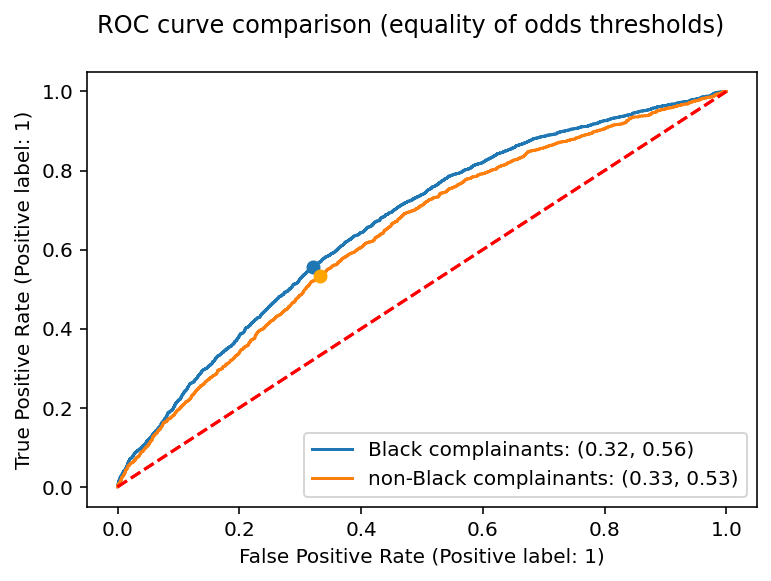

In [199]:
model_results_training_black = model_results_training.loc[model_results_training.black == True]
fpr_black, tpr_black, thresholds_black = metrics.roc_curve(model_results_training_black.ccrb,model_results_training_black.proba)

model_results_training_nb = model_results_training.loc[model_results_training.black == False]
fpr_nb, tpr_nb, thresholds_nb = metrics.roc_curve(model_results_training_nb.ccrb,model_results_training_nb.proba)

best_eo_index_black = list(thresholds_black).index(list(filter(lambda x: np.isclose(x, 0.522, atol=0.0001), sorted(thresholds_black,reverse=True)))[0])
best_eo_index_nb = list(thresholds_nb).index(list(filter(lambda x: np.isclose(x, 0.541, atol=0.001), sorted(thresholds_nb,reverse=True)))[0])

fig = plot_roc_curve( pl, model_results_training_black.drop(columns=['ccrb','proba']), model_results_training_black.ccrb)
fig = plot_roc_curve( pl, model_results_training_nb.drop(columns=['ccrb','proba']), model_results_training_nb.ccrb, ax = fig.ax_)
fig.figure_.suptitle("ROC curve comparison (equality of odds thresholds)")
plt.plot([fpr_black[best_eo_index_black]], [tpr_black[best_eo_index_black]], 'ro', color = 'tab:blue')
plt.plot([fpr_nb[best_eo_index_nb]], [tpr_nb[best_eo_index_nb]], 'ro', color = 'orange')
plt.legend(['Black complainants: ({}, {})'.format(round(fpr_black[best_eo_index_black],2),round(tpr_black[best_eo_index_black],2)),
            'non-Black complainants: ({}, {})'.format(round(fpr_nb[best_eo_index_nb],2),round(tpr_nb[best_eo_index_nb],2))])
plt.plot([(0,0), (1,1)], 'r--')
plt.show()

In [174]:
model_results_black = model_results.loc[model_results.black==True]
model_results_nb = model_results.loc[model_results.black==False]

In [175]:
best_threshold_black_eo = best_utilities_eo2.head(1)['black_threshold'].iloc[0]
best_threshold_nb_eo = best_utilities_eo2.head(1)['nb_threshold'].iloc[0]

In [797]:
# tp + fn: everything originally classified 1
denom_black_tpr = (model_results_black.substantiated==1).sum()
# tp: true is 1 and classified 1
num_black_tpr = (model_results_black.loc[model_results_black.substantiated==1].probability >= best_threshold_black_eo).sum()

# fp + tn: originally 0
denom_black_fpr = (model_results_black.substantiated==0).sum()
# fp: originally 0 but classified 1
num_black_fpr = (model_results_black.loc[model_results_black.substantiated==0].probability >= best_threshold_black_eo).sum()
black_tpr = num_black_tpr/denom_black_tpr
black_fpr = num_black_fpr/denom_black_fpr

denom_nb_tpr = (model_results_nb.substantiated==1).sum()
num_nb_tpr = (model_results_nb.loc[model_results_nb.substantiated==1].probability >= best_threshold_nb_eo).sum()
# fp + tn
denom_nb_fpr = (model_results_nb.substantiated==0).sum()
# fp
num_nb_fpr = (model_results_nb.loc[model_results_nb.substantiated==0].probability >= best_threshold_nb_eo).sum()
nb_tpr = num_nb_tpr/denom_nb_tpr
nb_fpr = num_nb_fpr/denom_nb_fpr

In [798]:
print("Observed Difference in True Positive Rate for Black complainants vs. non-Black complainants: {}".format(black_tpr - nb_tpr))

Observed Difference in True Positive Rate for Black complainants vs. non-Black complainants: 0.00762383900928798


In [799]:
print("Observed Difference in False Positive Rate for Black complainants vs. non-Black complainants: {}".format(black_fpr - nb_fpr))

Observed Difference in False Positive Rate for Black complainants vs. non-Black complainants: 0.005790638074168186


In [179]:
def group_wise_eth_dp(row):
    eth = row.black
    if eth:
        return row.probability >= best_threshold_black_eo
    else:
        return row.probability >= best_threshold_nb_eo
model_results['classification_gw_eo'] = model_results.apply(group_wise_eth_dp,axis=1)

In [180]:
def permutation_test_eo(df, observed_tp, observed_fp, n_repetitions):
    fpr_diffs = []
    tpr_diffs = []
    for _ in range(n_repetitions):
        # shuffle the statistic of interest
        shuffled_values = (df['black'].sample(replace=False, frac=1)
            .reset_index(drop=True))
        # put them in a table
        shuffled = df.copy().reset_index()
        shuffled['Shuffled Values'] = shuffled_values
        shuffled_black = shuffled.loc[shuffled['Shuffled Values'] == True]
        shuffled_nb = shuffled.loc[shuffled['Shuffled Values'] != True]
        # compute the group differences (test statistic!)
        denom_black_tpr = (shuffled_black.substantiated==1).sum()
        # tp: true is 1 and classified 1
        num_black_tpr = (shuffled_black.loc[(shuffled_black.substantiated==1) & (shuffled_black.classification_gw_eo==1)]).shape[0]

        # fp + tn: originally 0
        denom_black_fpr = (shuffled_black.substantiated==0).sum()
        # fp: originally 0 but classified 1
        num_black_fpr = (shuffled_black.loc[(shuffled_black.substantiated==0) & (shuffled_black.classification_gw_eo==1)]).shape[0]

        black_tpr = num_black_tpr/denom_black_tpr
        black_fpr = num_black_fpr/denom_black_fpr

        denom_nb_tpr = (shuffled_nb.substantiated==1).sum()
        num_nb_tpr = (shuffled_nb.loc[(shuffled_nb.substantiated==1) & (shuffled_nb.classification_gw_eo==1)]).shape[0]

        # fp + tn
        denom_nb_fpr = (shuffled_nb.substantiated==0).sum()
        # fp
        num_nb_fpr = (shuffled_nb.loc[(shuffled_nb.substantiated==0) & (shuffled_nb.classification_gw_eo==1)]).shape[0]

        nb_tpr = num_nb_tpr/denom_nb_tpr
        nb_fpr = num_nb_fpr/denom_nb_fpr
        # add it to the list of results
        fpr_diffs.append(black_fpr - nb_fpr)
        tpr_diffs.append(black_tpr - nb_tpr)
    # p-value to see if got any thing even smaller than observed
    p_value_neg_fpr = np.count_nonzero(np.array(fpr_diffs) < min([observed_fp, observed_fp*-1])) / n_repetitions
    # p-value to see if got any thing even bigger than observed
    p_value_pos_fpr = np.count_nonzero(np.array(fpr_diffs) > max([observed_fp, observed_fp*-1])) / n_repetitions
    p_value_fpr = p_value_neg_fpr + p_value_pos_fpr
    # p-value to see if got any thing even smaller than observed
    p_value_neg_tpr = np.count_nonzero(np.array(tpr_diffs) < min([observed_tp, observed_tp*-1])) / n_repetitions
    # p-value to see if got any thing even bigger than observed
    p_value_pos_tpr = np.count_nonzero(np.array(tpr_diffs) > max([observed_tp, observed_tp*-1])) / n_repetitions
    p_value_tpr = p_value_neg_tpr + p_value_pos_tpr
    return (fpr_diffs, p_value_fpr, tpr_diffs, p_value_tpr)

In [181]:
test_statistics_fpr, p_value_fpr, test_statistics_tpr, p_value_tpr = permutation_test_eo(model_results, black_tpr - nb_tpr, black_fpr - nb_fpr, 1000)

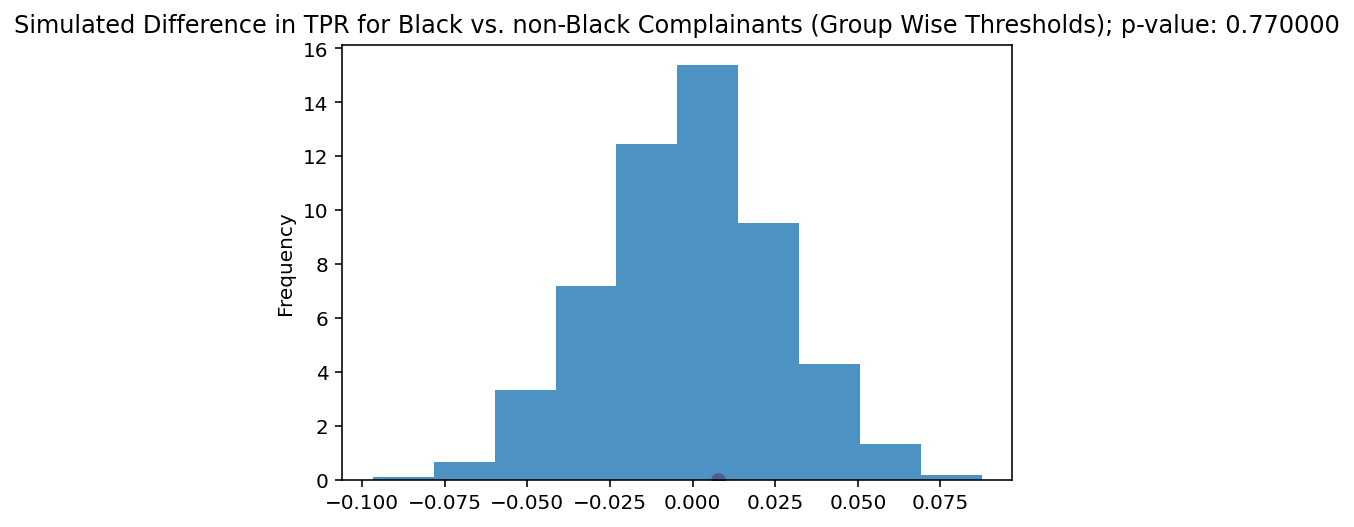

In [182]:
title = 'Simulated Difference in TPR for Black vs. non-Black Complainants (Group Wise Thresholds)'
title += '; p-value: %f' % p_value_tpr
(pd.Series(test_statistics_tpr)).plot(kind='hist', density=True, alpha=0.8, title=title)
plt.scatter(black_tpr - nb_tpr, 0, color='red', s=40)
plt.show()

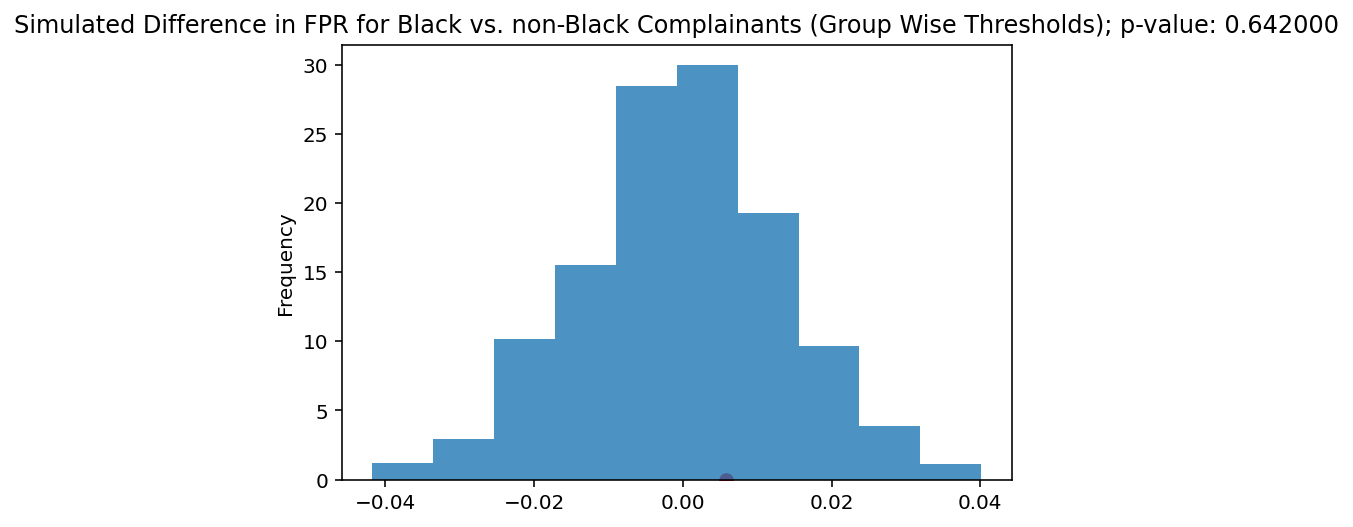

In [183]:
title = 'Simulated Difference in FPR for Black vs. non-Black Complainants (Group Wise Thresholds)'
title += '; p-value: %f' % p_value_fpr
(pd.Series(test_statistics_fpr)).plot(kind='hist', density=True, alpha=0.8, title=title)
plt.scatter(black_fpr - nb_fpr, 0, color='red', s=40)
plt.show()

### Predictive Value Parity

Since the group wise thresholds that maximize utility did not satisfy predictive value parity, there should be different thresholds that enforce predictive value parity. By iterating through possible thresholds and calculating the differences in PPV and NPV, the best thresholds found for holding predictive value parity were 0.522 for Black complainants and 0.535 for non-Black complainants. However, these thresholds do not hold on the test set, and the observed difference in PPV was found to be significantly different from 0 via permutation test at significance level 0.05. 

In [184]:
#threshold:[tpr, fpr]
black_dict_pv = {}
nb_dict_pv= {}
for t in np.arange(0.1, 1, 0.01):
    t = round(t,2)
    c1_black = model_results_training.loc[(model_results_training.proba >= t) & (model_results_training.black==True)]
    if (c1_black.shape[0] == 0) :
        continue
    sub_black = c1_black.loc[(c1_black.ccrb==True)]
    ppv_black = sub_black.shape[0] / c1_black.shape[0]
    c1_nb = model_results_training.loc[(model_results_training.proba >= t) & (model_results_training.black!=True)]
    if (c1_nb.shape[0] == 0) :
        continue
    sub_nb = c1_nb.loc[(c1_nb.ccrb==True)]
    ppv_nb = sub_nb.shape[0] / c1_nb.shape[0]    
    
    c0_black = model_results_training.loc[(model_results_training.proba < t) & (model_results_training.black==True)]
    if (c0_black.shape[0] == 0) :
        continue
    unsub_black = c0_black.loc[(c0_black.ccrb==False)]
    npv_black = unsub_black.shape[0] / c0_black.shape[0]
    c0_nb = model_results_training.loc[(model_results_training.proba < t) & (model_results_training.black!=True)]
    if (c0_nb.shape[0] == 0) :
        continue
    unsub_nb = c0_nb.loc[(c0_nb.ccrb==False)]
    npv_nb = unsub_nb.shape[0] / c0_nb.shape[0]
    
    black_dict_pv[t] = [ppv_black,npv_black]
    nb_dict_pv[t] = [ppv_nb,npv_nb]

In [185]:
results_pv = {}
for k in black_dict_pv:
    curr_black = black_dict_pv[k]
    tpr_black = curr_black[0]
    fpr_black = curr_black[1]
    if (tpr_black == 0) or (fpr_black == 0):
        continue
    for knb in nb_dict_pv:
        curr_nb = nb_dict_pv[knb]
        tpr_nb = curr_nb[0]
        fpr_nb = curr_nb[1]
        if tpr_nb == 0 or fpr_nb == 0:
            continue
        tpr_diff = np.abs(tpr_black - tpr_nb)
        fpr_diff = np.abs(fpr_black - fpr_nb)
        if (tpr_diff < 0.02) and (fpr_diff < 0.02):
            key = tuple([k,knb])
            if key in results_pv:
                curr_val = results_pv[key]
                curr_tpr = np.abs(curr_val[0])
                curr_fpr = np.abs(curr_val[1])
                if (tpr_diff < curr_tpr) and (fpr_diff < curr_fpr):
                    results_pv[key] = [tpr_black - tpr_nb, fpr_black - fpr_nb]
                else:
                    continue
            else:
                results_pv[key] = [tpr_black - tpr_nb, fpr_black - fpr_nb]
        else:
            continue

In [186]:
utility_results_pv = {}
for k in results_pv:
    black_thresh = k[0]
    nb_thresh = k[1]
    black_utility = calc_utility(df.loc[df.black == True],black_thresh, 0.4)
    nb_utility = calc_utility(df.loc[df.black == False],nb_thresh, 0.4)
    utility_results_pv[k] = (black_utility,nb_utility)

In [187]:
black_utilities_pv = list(map(lambda t: t[0], utility_results_pv.values()))
nb_utilities_pv = list(map(lambda t: t[1], utility_results_pv.values()))
black_threshs_pv = list(map(lambda t: t[0], utility_results_pv.keys()))
nb_threshs_pv = list(map(lambda t: t[1], utility_results_pv.keys()))
utility_df_pv = pd.DataFrame(data = {'black_threshold':black_threshs_pv,'nb_threshold':nb_threshs_pv,'black_utility':black_utilities_pv,'nb_utility':nb_utilities_pv})
best_utilities_pv = utility_df_pv.sort_values(['black_utility','nb_utility'],ascending=False).head(10)
best_utilities_pv['mean_utility'] = (best_utilities_pv.black_utility + best_utilities_pv.nb_utility)/2

In [188]:
#threshold:[tpr, fpr]
black_dict_pv2 = {}
nb_dict_pv2= {}
for t in np.arange(0.515, 0.535, 0.001):
    c1_black = model_results_training.loc[(model_results_training.proba >= t) & (model_results_training.black==True)]
    if (c1_black.shape[0] == 0) :
        continue
    sub_black = c1_black.loc[(c1_black.ccrb==True)]
    ppv_black = sub_black.shape[0] / c1_black.shape[0]
    c1_nb = model_results_training.loc[(model_results_training.proba >= t) & (model_results_training.black!=True)]
    if (c1_nb.shape[0] == 0) :
        continue
    sub_nb = c1_nb.loc[(c1_nb.ccrb==True)]
    ppv_nb = sub_nb.shape[0] / c1_nb.shape[0]    
    
    c0_black = model_results_training.loc[(model_results_training.proba < t) & (model_results_training.black==True)]
    if (c0_black.shape[0] == 0) :
        continue
    unsub_black = c0_black.loc[(c0_black.ccrb==False)]
    npv_black = unsub_black.shape[0] / c0_black.shape[0]
    c0_nb = model_results_training.loc[(model_results_training.proba < t) & (model_results_training.black!=True)]
    if (c0_nb.shape[0] == 0) :
        continue
    unsub_nb = c0_nb.loc[(c0_nb.ccrb==False)]
    npv_nb = unsub_nb.shape[0] / c0_nb.shape[0]
    
    black_dict_pv2[t] = [ppv_black,npv_black]
    nb_dict_pv2[t] = [ppv_nb,npv_nb]
results_pv2 = {}
for k in black_dict_pv2:
    curr_black = black_dict_pv2[k]
    tpr_black = curr_black[0]
    fpr_black = curr_black[1]
    if (tpr_black == 0) or (fpr_black == 0):
        continue
    for knb in nb_dict_pv2:
        curr_nb = nb_dict_pv2[knb]
        tpr_nb = curr_nb[0]
        fpr_nb = curr_nb[1]
        if tpr_nb == 0 or fpr_nb == 0:
            continue
        tpr_diff = np.abs(tpr_black - tpr_nb)
        fpr_diff = np.abs(fpr_black - fpr_nb)
        if (tpr_diff < 0.02) and (fpr_diff < 0.02):
            key = tuple([k,knb])
            if key in results_pv2:
                curr_val = results_pv2[key]
                curr_tpr = np.abs(curr_val[0])
                curr_fpr = np.abs(curr_val[1])
                if (tpr_diff < curr_tpr) and (fpr_diff < curr_fpr):
                    results_pv2[key] = [tpr_black - tpr_nb, fpr_black - fpr_nb]
                else:
                    continue
            else:
                results_pv2[key] = [tpr_black - tpr_nb, fpr_black - fpr_nb]
        else:
            continue
utility_results_pv2 = {}
for k in results_pv2:
    black_thresh = k[0]
    nb_thresh = k[1]
    black_utility = calc_utility(df.loc[df.black == True],black_thresh, 0.4)
    nb_utility = calc_utility(df.loc[df.black == False],nb_thresh, 0.4)
    utility_results_pv2[k] = (black_utility,nb_utility)

In [208]:
black_utilities_pv2 = list(map(lambda t: t[0], utility_results_pv2.values()))
nb_utilities_pv2 = list(map(lambda t: t[1], utility_results_pv2.values()))
black_threshs_pv2 = list(map(lambda t: t[0], utility_results_pv2.keys()))
nb_threshs_pv2 = list(map(lambda t: t[1], utility_results_pv2.keys()))
utility_df_pv2 = pd.DataFrame(data = {'black_threshold':black_threshs_pv2,'nb_threshold':nb_threshs_pv2,'black_utility':black_utilities_pv2,'nb_utility':nb_utilities_pv2})
best_utilities_pv2 = utility_df_pv2.sort_values(['black_utility','nb_utility'],ascending=False).head(10)
best_utilities_pv2['mean_utility'] = (best_utilities_pv2.black_utility + best_utilities_pv2.nb_utility)/2

In [209]:
print('Thresholds That Satisfy Predictive Value Parity and Yield Highest Utility')
best_utilities_pv2.head(1)

Thresholds That Satisfy Predictive Value Parity and Yield Highest Utility


,black_threshold,nb_threshold,black_utility,nb_utility,mean_utility
157,0.522,0.535,0.625187,0.606752,0.61597


In [212]:
best_threshold_black_pv = best_utilities_pv2.head(1)['black_threshold'].iloc[0]
best_threshold_nb_pv = best_utilities_pv2.head(1)['nb_threshold'].iloc[0]

In [801]:
c1_black = model_results.loc[(model_results.probability >= best_threshold_black_pv) & (model_results.black==True)]
sub_black = c1_black.loc[(c1_black.substantiated==True)]
ppv_black = sub_black.shape[0] / c1_black.shape[0]
c1_nb = model_results.loc[(model_results.probability >= best_threshold_nb_pv) & (model_results.black!=True)]
sub_nb = c1_nb.loc[(c1_nb.substantiated==True)]
ppv_nb = sub_nb.shape[0] / c1_nb.shape[0]
print("Observed Difference in Positive Predictive Value for Black complainants vs. non-Black complainants: {}".format(ppv_black - ppv_nb))

Observed Difference in Positive Predictive Value for Black complainants vs. non-Black complainants: -0.04103196978150031


In [217]:
def group_wise_pv(row):
    eth = row.black
    if eth:
        return row.probability >= best_threshold_black_pv
    else:
        return row.probability >= best_threshold_nb_pv

In [218]:
model_results['classification_pv'] = model_results.apply(group_wise_pv, axis=1)

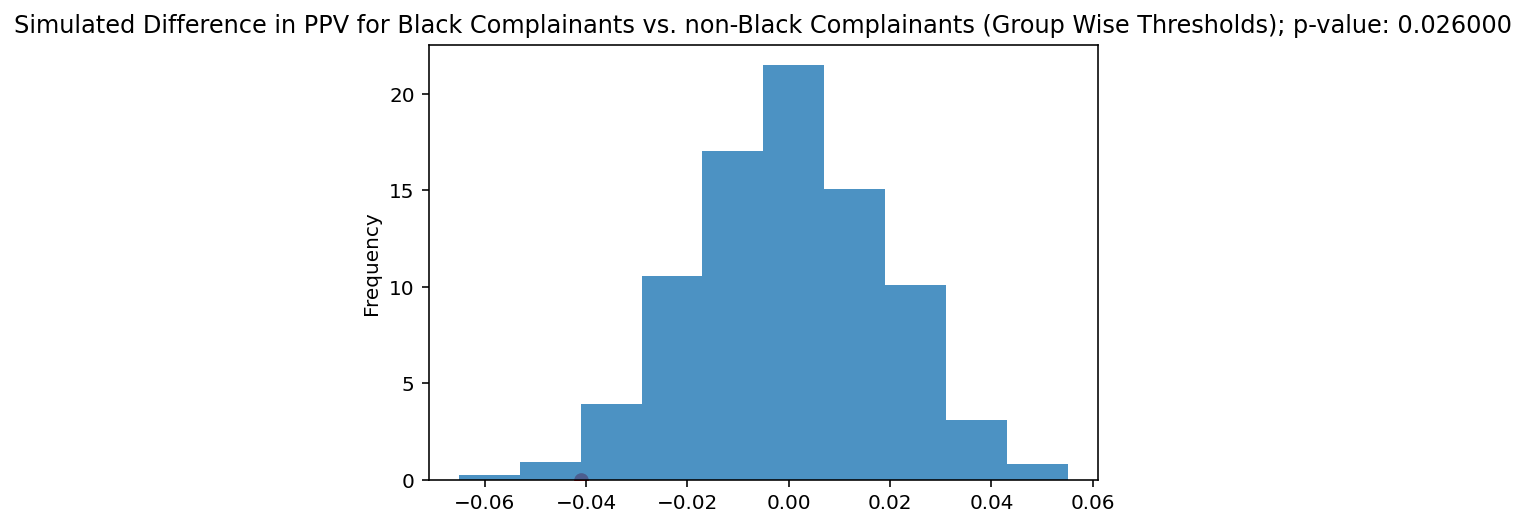

In [219]:
def permutation_test_ppv(df, observed, n_repetitions):
    test_statistics = []
    for _ in range(n_repetitions):
        # shuffle the statistic of interest
        shuffled_values = (df['black'].sample(replace=False, frac=1)
            .reset_index(drop=True))
        # put them in a table
        shuffled = df.copy().reset_index()
        shuffled['Shuffled Values'] = shuffled_values
        c1_black = shuffled.loc[(shuffled.classification_pv == 1) & (shuffled['Shuffled Values']==True)]
        sub_black = c1_black.loc[(c1_black.substantiated==True)]
        ppv_black = sub_black.shape[0] / c1_black.shape[0]
        c1_nb = shuffled.loc[(shuffled.classification_pv == 1) & (shuffled['Shuffled Values']!=True)]
        sub_nb = c1_nb.loc[(c1_nb.substantiated==True)]
        ppv_nb = sub_nb.shape[0] / c1_nb.shape[0]
        difference = (ppv_black - ppv_nb)
        test_statistics.append(difference)
        # difference in means:
    # p-value to see if got any thing even smaller than observed
    p_value_neg = np.count_nonzero(np.array(test_statistics) < min([observed, observed*-1])) / n_repetitions
    # p-value to see if got any thing even bigger than observed
    p_value_pos = np.count_nonzero(np.array(test_statistics) > max([observed, observed*-1])) / n_repetitions
    p_value = p_value_neg + p_value_pos
    return (test_statistics, p_value)
test_stats_ppv_gw, p_value_ppv_gw = permutation_test_ppv(model_results, ppv_black - ppv_nb, 1000 )
title = 'Simulated Difference in PPV for Black Complainants vs. non-Black Complainants (Group Wise Thresholds)'
title += '; p-value: %f' % p_value_ppv_gw
(pd.Series(test_stats_ppv_gw)).plot(kind='hist', density=True, alpha=0.8, title=title)
plt.scatter((ppv_black - ppv_nb), 0, color='red', s=40)
plt.show()

In [802]:
c0_black = model_results.loc[(model_results.probability < best_threshold_black_pv) & (model_results.black==True)]
unsub_black = c0_black.loc[(c0_black.substantiated==False)]
npv_black = unsub_black.shape[0] / c0_black.shape[0]
c0_nb = model_results.loc[(model_results.probability < best_threshold_nb_pv) & (model_results.black!=True)]
unsub_nb = c0_nb.loc[(c0_nb.substantiated==False)]
npv_nb = unsub_nb.shape[0] / c0_nb.shape[0]
print("Observed Difference in Negative Predictive Value for Black complainants vs. non-Black complainants: {}".format(npv_black - npv_nb))

Observed Difference in Negative Predictive Value for Black complainants vs. non-Black complainants: 0.025867291984561613


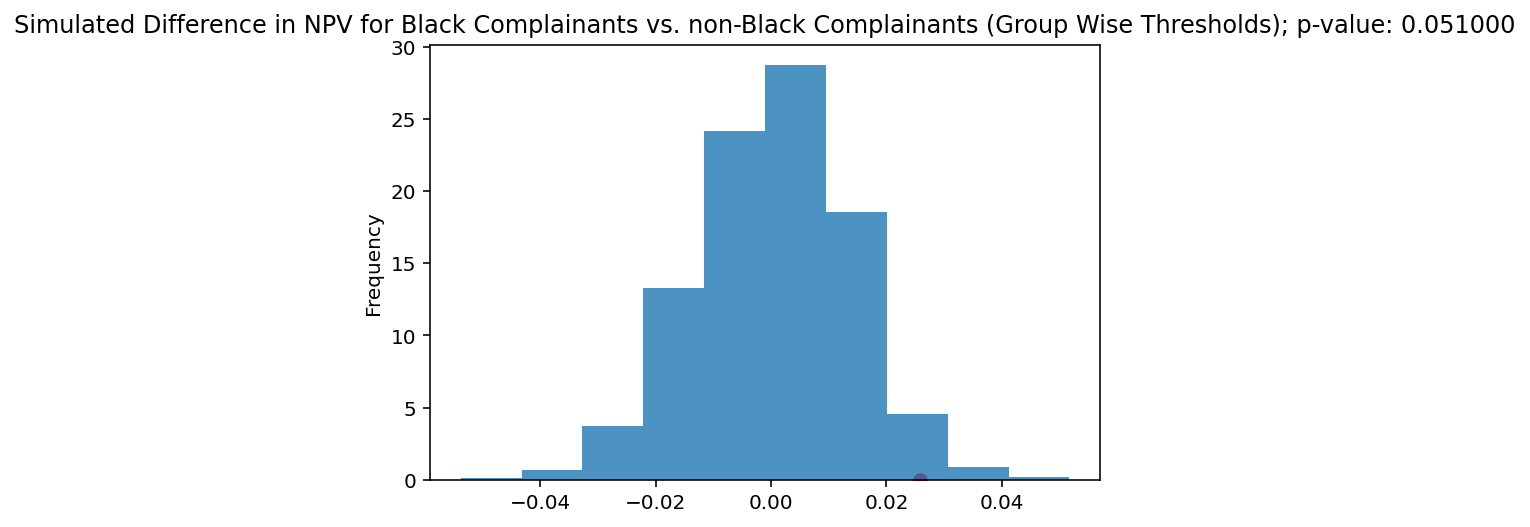

In [221]:
def permutation_test_npv(df, observed, n_repetitions):
    test_statistics = []
    for _ in range(n_repetitions):
        # shuffle the statistic of interest
        shuffled_values = (df['black'].sample(replace=False, frac=1)
            .reset_index(drop=True))
        # put them in a table
        shuffled = df.copy().reset_index()
        shuffled['Shuffled Values'] = shuffled_values
        c0_black = shuffled.loc[(shuffled.classification_pv == 0) & (shuffled['Shuffled Values']==True)]
        unsub_black = c0_black.loc[(c0_black.substantiated==False)]
        npv_black = unsub_black.shape[0] / c0_black.shape[0]
        c0_nb = shuffled.loc[(shuffled.classification_pv == 0) & (shuffled['Shuffled Values']!=True)]
        unsub_nb = c0_nb.loc[(c0_nb.substantiated==False)]
        npv_nb = unsub_nb.shape[0] / c0_nb.shape[0]
        difference = (npv_black - npv_nb)
        test_statistics.append(difference)
        # difference in means:
    # p-value to see if got any thing even smaller than observed
    p_value_neg = np.count_nonzero(np.array(test_statistics) < min([observed, observed*-1])) / n_repetitions
    # p-value to see if got any thing even bigger than observed
    p_value_pos = np.count_nonzero(np.array(test_statistics) > max([observed, observed*-1])) / n_repetitions
    p_value = p_value_neg + p_value_pos
    return (test_statistics, p_value)
test_stats_npv_gw, p_value_npv_gw = permutation_test_npv(model_results, npv_black - npv_nb, 1000 )
title = 'Simulated Difference in NPV for Black Complainants vs. non-Black Complainants (Group Wise Thresholds)'
title += '; p-value: %f' % p_value_npv_gw
(pd.Series(test_stats_npv_gw)).plot(kind='hist', density=True, alpha=0.8, title=title)
plt.scatter(npv_black - npv_nb, 0, color='red', s=40)
plt.show()

## Thresholds Summary
Depending on what is most important to the decision-making body (CCRB), different threshold(s) would be chosen. Maximizing utility overall enforces equality for all complainants, while maximizing utility for each group is more equitable. Satisfying demographic parity ensures that substantiation doesn't depend on complainant ethnicity. Equality of odds would focus on ensuring that the chance of obtaining the benefit of substantiation is equal across groups, while predictive value parity focuses on ensuring deserving complainants receive substantiation and un-derserving complainants don't. While I believe that predictive value parity should be the priority, the CCRB may think otherwise and would thus choose the thresholds accordingly. See below for a table summarizing all the thresholds tested and what parity measure(s) they satisfy (if any).

In [227]:
thresholds_dict = {'Threshold for Black Complainants':[0.527, 0.522, 0.522, 0.522], 'Threshold for non-Black Complainants':[0.527,0.546,0.541,0.535],
                  'Test':['Max utility overall', 'Max utility per group', 'Enforce equality of odds', 'Enforce predictive value parity'],
                  'Demographic Parity':['Not satisfied', 'Satisfied', 'N/A', 'N/A'], 'Equality of Odds':['Not satisfied', 'Satisfied', '*Strictly* satisfied', 'N/A'],
                  'Predictive Value Parity':['Satisfied', 'Not satisfied', 'N/A', 'Not satisfied']}

In [228]:
pd.DataFrame(data=thresholds_dict)

,Threshold for Black Complainants,Threshold for non-Black Complainants,Test,Demographic Parity,Equality of Odds,Predictive Value Parity
0,0.527,0.527,Max utility overall,Not satisfied,Not satisfied,Satisfied
1,0.522,0.546,Max utility per group,Satisfied,Satisfied,Not satisfied
2,0.522,0.541,Enforce equality of odds,N/A,*Strictly* satisfied,N/A
3,0.522,0.535,Enforce predictive value parity,N/A,N/A,Not satisfied


# Luck Egalitarian Preprocessing: Decorrelating The Features and Sensitive Attribute Complainant Ethnicity 

The threshold tests performed above are an example of using post-processing to create a fairer classifier. This may not be applicable in all cases because it requires access to the sensitive attribute (complainant ethnicity) at score time. In this context, using the complainant’s ethnicity when determining if their complaint should be substantiated may not be appropriate. 

With preprocessing, the sensitive attribute is not needed when training or testing the model. This would mean that the CCRB would not need to know the complainant’s ethnicity when making their decision. This assumption could be more applicable for the CCRB because of potential legal issues that would arise when directly using complainant ethnicity in the decision. 

Luck egalitarian preprocessing seeks to “level the playing field” by decorrelating the features from the sensitive attribute. This would make the overall distribution of features the same across sensitive groups while also maintaining the relative ranking/order within groups. In Paper 1, it was discussed that Black New Yorkers more often interact with the police and that Black neighborhoods have different interactions with the police in general. This would imply that the playing field is not level across ethnicity. Preprocessing would attempt to level the playing field in the data so that the model evaluates complainants on their relative circumstances. 

Example: The data shows that Black complainants are more likely to make allegations related to abuse of authority (a more severe allegation) than non-Black complainants, and non-Black complainants make more allegations related to discourtesy (a less severe allegation). With preprocessing, the data will be manipulated so that the general distribution of severity of allegations is the same across complainants while maintaining that distribution within the groups. A complaint regarding abuse of authority would send the same “signal” to the model despite ethnicity, but within groups, the same relative severity will hold. 

To implement this decorrelation, I followed the process presented in *Certifying and removing disparate impact* (Feldman et al., 2015):

1. Remove the sensitive attribute (complainant ethnicity) and all other protected attributes (officer ethnicity, officer/complainant age, and officer/complainant gender).
2. Remove unordered categorical variables (borough) and convert ordered categories (allegation, type of complaint, and officer rank) to integers. 
    - Contact reason was dropped because most of complaints fall under “other” or simple violation, making it difficult to determine any order from the limited variance. 
    - Order of allegation and type of complainant was based on the NYPD *Disciplinary System Penalty Guidelines* (New York City Police Department, 2021). 
    - Order of officer rank was based "Duties of the NYPD ranks" (Zander, 2018).
        - Note that officer rank was treated as unordered originally, but due to lack of remaining features, it was retained for this model. 
3. Scale all features so that minimum is 0 and maximum is 1.
4. Calculate the group-wise quantiles of each feature and take the median for each feature’s quantiles.
5. Convert the original data so that the original value is transformed to the median of its percentile. For example, if feature $x_1$ for a Black complainant falls in the 20th percentile for all Black complainants, look at the 20th percentile in the median distribution (the median of the 20th percentile values for both Black and non-Black complainants). 
6. Train the model on this decorrelated data. 
    - The threshold that maximized utility for this new model was 0.546, compared to 0.527 in the original model.  

Ideally, this decorrelation process will reduce any infra-marginality seen between the two groups while maintaining any relevant comparisons within groups. Since Black complainants in the 20th percentile of their group and non-Black complainants in the 20th percentile of their group are the same in the eyes of the model, we would assume the model’s prediction to be the same for both of them, despite complainant ethnicity. This similarity across groups is what would make the model fair. 

Model performance in terms of precision and recall both overall and across groups remained generally the same compared to the original model and the model trained on the decorrelated data. Since fairness and parity measures are the emphasis of this exercise, these will be looked at more closely. With making the features, and in turn the model, independent of the sensitive attribute complainant ethnicity, we assume demographic parity to hold. 

In [584]:
def transform_allegation_le(X):
    '''
    function that simplifies/bins the allegation column
    '''
    # possible bins for allegation
    allegation_categories = ['restricted','gun','chokehold','beat',
        'sex','sexual','threat','arrest','action','spray','physical','strip',
        'frisk','retaliatory','premise','search','stop','vehicle',
        'property','seizure','refusal','question','word','other'][::-1]
    def transform(s):
        to_return = []
        for a in allegation_categories:
            if a in s:
                to_return.append(a)
        if len(to_return) == 0:
            return 'other'
        else:
            return to_return[0]
            
    lower = X['allegation'].str.lower()
    return lower.apply(transform).to_frame()

In [457]:
allegation_categories = ['restricted','gun','chokehold','beat',
        'sex','sexual','threat','arrest','action','spray','physical','strip',
        'frisk','retaliatory','premise','search','stop','vehicle',
        'property','seizure','refusal','question','word','other'][::-1]

In [648]:
def preprocessor_le():
    '''
    function containing all preprocessing/transformation of features
    done before fitting the model
    '''
    # remove all unodered categorical variables
    categ = ['allegation','fado_type']
    baseline_dates = ['year_received','month_received','year_closed','month_closed']
    # all possible values of fado_type. ordered from least to most serious 
    fado_categories = ['Abuse of Authority','Force',
                       'Discourtesy','Offensive Language'][::-1]
    ranks = ['Police Officer', 'Detective', 'Sergeant', 
'Lieutenant','Captain', 'Deputy Inspector','Inspector']
    
    alleg_categories = ['restricted','gun','chokehold','beat',
        'sex','sexual','threat','arrest','action','spray','physical','strip',
        'frisk','retaliatory','premise','search','stop','vehicle',
        'property','seizure','refusal','question','word','other'][::-1]
    elapsed = Pipeline(steps=[
        ('elapsed', FunctionTransformer(transform_dates)),
        ('scaled', MinMaxScaler())
        ])
    # ordinal encode fado 
    fado = Pipeline(steps=[
        ('fado', OrdinalEncoder(categories=[fado_categories])),
        ('scaled', MinMaxScaler())
        ])
    # simplify/bin allegation, then use ordinal encoding
    alleg = Pipeline(steps=[
        ('transform', FunctionTransformer(transform_allegation_le, validate=False)),
        ('alleg', OrdinalEncoder(categories=[alleg_categories])),
        ('scaled', MinMaxScaler())
        ])
    rank = Pipeline(steps=[
        ('rank', OrdinalEncoder(categories=[ranks])),
        ('scaled', MinMaxScaler())
        ])
    preproc = ColumnTransformer(
        transformers=[
            ('alleg', alleg, ['allegation']),
            ('fad', fado, ['fado_type']),
            ('rank', rank, ['rank_incident']),
            ('elapsed', elapsed, baseline_dates)])
    return preproc

In [649]:
ct = preprocessor_le()

In [650]:
# ordinal and/or engineered variables
categ = ['allegation','fado_type','rank_incident']
# quantitiative variable
# baseline_feats_num = ['complainant_age_incident','mos_age_incident',]
# date columns to find time elapsed
baseline_dates = ['year_received','month_received','year_closed','month_closed']
# categories for fado_type ordinal encoding
fado_categories = ['Abuse of Authority','Force','Discourtesy','Offensive Language'][::-1]
# drop all missing data
model_df = complaints.dropna()
X_le = model_df[categ+baseline_dates]

In [651]:
transformed = ct.fit_transform(X_le)

In [653]:
transformed_df = pd.DataFrame(data=transformed, columns = list(categ + ['elapsed']))

In [654]:
transformed_df['black'] = model_df.reset_index().black

In [655]:
# 50th Percentile
def complainant_age_elapsed(x):
    return x.quantile(np.arange(0,1.01,0.05))

def mos_age(x):
    return x.quantile(np.arange(0,1.01,0.05))

def allegation(x):
    return x.quantile(np.arange(0,1.01,0.05))

def fado(x):
    return x.quantile(np.arange(0,1.01,0.5))
def rank(x):
    return x.quantile(np.arange(0,1.01,0.25))

In [606]:
allegation_df = pd.concat([allegation(transformed_df.loc[transformed_df.black==False].allegation).to_frame(name='nb'),
           allegation(transformed_df.loc[transformed_df.black].allegation).to_frame(name='black')],axis=1)
allegation_df['med'] = allegation_df.median(axis=1)
allegation_df['percentile'] = allegation_df.index

In [607]:
fado_df = pd.concat([fado(transformed_df.loc[transformed_df.black==False].fado_type).to_frame(name='nb'),
           fado(transformed_df.loc[transformed_df.black].fado_type).to_frame(name='black')],axis=1)
fado_df['med'] = fado_df.median(axis=1)
fado_df['percentile'] = fado_df.index

In [608]:
elapsed_df = pd.concat([complainant_age_elapsed(transformed_df.loc[transformed_df.black==False].elapsed).to_frame(name='nb'),
           complainant_age_elapsed(transformed_df.loc[transformed_df.black].elapsed).to_frame(name='black')],axis=1)
elapsed_df['med'] = elapsed_df.median(axis=1)
elapsed_df['percentile'] = elapsed_df.index

In [656]:
rank_df = pd.concat([rank(transformed_df.loc[transformed_df.black==False].rank_incident).to_frame(name='nb'),
           complainant_age_elapsed(transformed_df.loc[transformed_df.black].rank_incident).to_frame(name='black')],axis=1)
rank_df['med'] = rank_df.median(axis=1)
rank_df['percentile'] = rank_df.index

In [657]:
transformed_df_decorr = transformed_df.copy()

In [610]:
def decorrelate_one(val, df):
    percentiles = df.percentile.sort_values(ascending=False)
    for i in percentiles:
        if val>=i:
            return df.loc[i].med

In [659]:
# order: ['complainant_age_incident','mos_age_incident','allegation','fado_type',elapsed]
def decorrelate(row):
    black = row['black']
    if black:
        vals_df = transformed_df.loc[transformed_df.black==True]
    else:
        vals_df = transformed_df.loc[transformed_df.black!=True]
#     compl = stats.percentileofscore(vals_df.complainant_age_incident,row['complainant_age_incident']) / 100
#     mos = stats.percentileofscore(vals_df.mos_age_incident,row['mos_age_incident']) / 100
    alleg = stats.percentileofscore(vals_df.allegation,row['allegation']) / 100
    fado = stats.percentileofscore(vals_df.fado_type,row['fado_type']) / 100
    elap = stats.percentileofscore(vals_df.elapsed,row['elapsed']) / 100
    ran = stats.percentileofscore(vals_df.elapsed,row['rank_incident']) / 100
    return [decorrelate_one(alleg,allegation_df),
           decorrelate_one(fado, fado_df),
            decorrelate_one(ran, rank_df),
           decorrelate_one(elap, elapsed_df)]

In [660]:
transformed_df_decorr = pd.DataFrame(data=list(transformed_df_decorr.apply(decorrelate, axis=1)))

In [661]:
transformed_df_decorr.columns = transformed_df.columns[:-1]

In [663]:
X_tr_le, X_ts_le, y_tr_le, y_ts_le = train_test_split(transformed_df_decorr,
        model_df.reset_index().substantiated,random_state=11)
weights = {0: model_df.shape[0] / (2 * (complaints.substantiated.value_counts()[0])), 1:model_df.shape[0] / (2 * (complaints.substantiated.value_counts()[1]))}

pl_le = Pipeline(steps=[('classifier', LogisticRegression(random_state = 8888, class_weight=weights))])
fitted = pl_le.fit(X_tr_le, y_tr_le)

In [664]:
training_results_le = pl_le.predict_proba(X_tr_le)

In [665]:
model_results_training_le = X_tr_le.copy()

In [666]:
model_results_training_le['proba'] = training_results_le[:,1]

In [667]:
model_results_training_le['ccrb'] = y_tr_le

In [668]:
df_le = model_results_training_le[['proba', 'ccrb']]

In [669]:
best_threshold_le, utility_le = find_best_thresh(df_le,0.4)
fpr_le, tpr_le, thresholds_le = metrics.roc_curve(model_results_training_le.ccrb,model_results_training_le.proba)
best_index_le = list(thresholds_le).index(list(filter(lambda x: np.isclose(x, best_threshold_le, atol=0.001), thresholds_le))[0])
best_threshold_le = round(thresholds_le[best_index_le],3)
fpr_best_le = round(fpr_le[best_index_le],2)
tpr_best_le = round(tpr_le[best_index_le],2)

In [670]:
best_threshold, utility = find_best_thresh(df,0.4)
fpr, tpr, thresholds = metrics.roc_curve(model_results_training.ccrb,model_results_training.proba)
best_index = list(thresholds).index(list(filter(lambda x: np.isclose(x, best_threshold, atol=0.0001), thresholds))[0])
best_threshold = round(thresholds[best_index],3)
fpr_best = round(fpr[best_index],2)
tpr_best = round(tpr[best_index],2)

In [672]:
results_le = (pl_le, pl_le.predict_proba(X_ts_le)[:,1]>=best_threshold_le)
score_le = metrics.accuracy_score(y_ts_le, results_le[1])

In [762]:
def print_metrics_le(X_ts, y_ts):
    results = (pl_le, pl_le.predict_proba(X_ts)[:,1]>=best_threshold_le)
    score = metrics.accuracy_score(y_ts, results[1])
    # performance
    print(f'Accuracy Score: {metrics.accuracy_score(y_ts,results[1])}')
    print(f'Recall score: {metrics.recall_score(y_ts,results[1])}')
    print(f'Precision score: {metrics.precision_score(y_ts,results[1])}')
    print(f'F1 score: {metrics.f1_score(y_ts,results[1])}')

In [674]:
X_tr_le['black'] = transformed_df.loc[X_tr_le.index].black
X_ts_le['black'] = transformed_df.loc[X_ts_le.index].black

In [675]:
X_tr_black_le = X_tr_le.loc[X_tr_le.black == True]
y_tr_black_le = y_tr_le.loc[X_tr_black_le.index]
X_tr_nb_le = X_tr_le.loc[X_tr_le.black != True]
y_tr_nb_le = y_tr_le.loc[X_tr_nb_le.index]

In [676]:
X_ts_black_le = X_ts_le.loc[X_ts_le.black == True]
X_ts_nb_le = X_ts_le.loc[X_ts_le.black != True]
y_ts_nb_le = y_ts_le.loc[X_ts_nb_le.index]
y_ts_black_le = y_ts_le.loc[X_ts_black_le.index]

In [763]:
print('Test Performance For All Groups:')
print_metrics_le(X_ts_le.drop(columns=['black']), y_ts_le)

Test Performance For All Groups:
Accuracy Score: 0.6129716623730869
Recall score: 0.5638957816377171
Precision score: 0.3293478260869565
F1 score: 0.41582799634034767


In [764]:
print('Test Performance For Black Complainants:')
print_metrics_le(X_ts_black_le.drop(columns=['black']), y_ts_black_le)

Test Performance For Black Complainants:
Accuracy Score: 0.6006221584111031
Recall score: 0.5908629441624366
Precision score: 0.31493506493506496
F1 score: 0.4108718672785034


In [766]:
print('Test Performance For Non-Black Complainants:')
print_metrics_le(X_ts_nb_le.drop(columns=['black']), y_ts_nb_le)

Test Performance For Non-Black Complainants:
Accuracy Score: 0.6342975206611571
Recall score: 0.5215311004784688
Precision score: 0.35855263157894735
F1 score: 0.42495126705653014


## Demographic Parity

In the original model (prior to threshold tests), the model substantiated Black civilians’ complaints about 6% less often than it did for non-Black complaints. Rather than moving this difference to 0, the new model switched the direction of the violation of demographic parity. Instead of a difference in substantiation rate of 0, the new model substantiated complaints from Black civilians 6.5% *more* often than it did complaints from non-Black civilians. It seems that this decorrelation may be an overcorrection of sorts when compared to the original model. 

In [680]:
model_results_le = X_ts_le.copy()
model_results_le['classification'] = pl_le.predict_proba(X_ts_le.drop(columns=['black']))[:,1] >= best_threshold_le
model_results_le['probability'] = pl_le.predict_proba(X_ts_le.drop(columns=['black']))[:,1] 

In [681]:
# pivot table showing number of complaints of each disposition for black and nonblack complainants
nb_sub = model_results_le.pivot_table(index='black', 
                        columns='classification', aggfunc='size',fill_value=0)
sums = nb_sub.sum(axis=1)
# calculate the proportions of complaints submitted by black and nonblack complainants
# that got substantiated
nb_sub['Substantiated'] =  nb_sub[1] / sums
nb_sub['Not Substantiated'] =  nb_sub[0] / sums
# proportion of all complaints filed by black complainants and nonblack complainants 
prop_black_comp = model_results_le.loc[model_results_le['black']].shape[0]/model_results_le.shape[0]
print('Model Substantiation Rates for Black Complainants vs. non-Black Complainants')
nb_sub['Overall Proportion'] = [1-prop_black_comp, prop_black_comp]
nb_sub[['Substantiated', 'Overall Proportion']]

Model Substantiation Rates for Black Complainants vs. non-Black Complainants


classification,Substantiated,Overall Proportion
black,,
False,0.376860,0.366722
True,0.442211,0.633278


In [682]:
observed = nb_sub['Substantiated'][True]-nb_sub['Substantiated'][False]
print('Observed Difference in Model Substantiation Rate for Black vs. non-Black Complainants: {}'.format(observed))

Observed Difference in Model Substantiation Rate for Black vs. non-Black Complainants: 0.06535155114415053


In [699]:
# def permutation_test(df, observed, n_repetitions):
#     test_statistics = []
#     for _ in range(n_repetitions):
#         # shuffle the statistic of interest
#         shuffled_values = (df['black'].sample(replace=False, frac=1)
#             .reset_index(drop=True))
#         # put them in a table
#         shuffled = df.copy().reset_index()
#         shuffled['Shuffled Values'] = shuffled_values
#         # compute the group differences (test statistic!)
#         # difference in means:
#         nb_disposition = shuffled.pivot_table(index='Shuffled Values', 
#                             columns='classification', aggfunc='size',fill_value=0)
#         sums = nb_disposition.sum(axis=1)
#         nb_disposition['Substantiated'] =  nb_disposition[1] / sums
#         difference = nb_disposition['Substantiated'][1]-nb_disposition['Substantiated'][0]
#         # add it to the list of results
#         test_statistics.append(difference)
#     # p-value to see if got any thing even smaller than observed
#     p_value_neg = np.count_nonzero(np.array(test_statistics) < min([observed, observed*-1])) / n_repetitions
#     # p-value to see if got any thing even bigger than observed
#     p_value_pos = np.count_nonzero(np.array(test_statistics) > max([observed, observed*-1])) / n_repetitions
#     p_value = p_value_neg + p_value_pos
#     return (test_statistics, p_value)
# test_statistics_eth, p_value_eth = permutation_test(model_results_le, observed, 1000)
# title = 'Simulated Difference in Model Substantiation Rates for Black Complainants and non-Black Complainants'
# title += '; p-value: %f' % p_value_eth
# (pd.Series(test_statistics_eth)).plot(kind='hist', density=True, alpha=0.8, title=title)
# plt.scatter(observed, 0, color='red', s=40)
# plt.show()

## Equality of Odds
Since the model should be independent of complainant ethnicity, we could expect equality of odds to also be satisfied. However, the new model seemed to overcorrect once again. The true positive rate for Black complainants went from being 6.8% lower in the original model to 6.9% greater than that for non-Black complainants in the new model. The difference in false positive rate between Black and non-Black complainants went from -4.7% to +2.9%. At the 0.05 significance level, permutation tests revealed that both true positive and false positive parity are not met by the new model. 

In [684]:
model_results_le['substantiated'] = y_ts_le

In [806]:
sub_black = model_results_le.loc[(model_results_le.substantiated == True) & (model_results_le.black==True)]
sub_black_tp = sub_black.loc[(sub_black.classification==1)]
tpr_black = sub_black_tp.shape[0] / sub_black.shape[0]
sub_nb = model_results_le.loc[(model_results_le.substantiated == True) & (model_results_le.black!=True)]
sub_nb_tp = sub_nb.loc[(sub_nb.classification==1)]
tpr_nb = sub_nb_tp.shape[0] / sub_nb.shape[0]
print("Observed Difference in True Positive Rate for Black complainants vs. non-Black complainants: {}".format(tpr_black - tpr_nb))

Observed Difference in True Positive Rate for Black complainants vs. non-Black complainants: 0.06933184368396772


In [807]:
unsub_black = model_results_le.loc[(model_results_le.substantiated == False) & (model_results_le.black==True)]
sub_black_fp = unsub_black.loc[(unsub_black.classification==1)]
fpr_black = sub_black_fp.shape[0] / unsub_black.shape[0]
unsub_nb = model_results_le.loc[(model_results_le.substantiated == False) & (model_results.black!=True)]
sub_nb_fp = unsub_nb.loc[(unsub_nb.classification==1)]
fpr_nb = sub_nb_fp.shape[0] / unsub_nb.shape[0]
print("Observed Difference in False Positive Rate for Black complainants vs. non-Black complainants: {}".format(fpr_black - fpr_nb))

Observed Difference in False Positive Rate for Black complainants vs. non-Black complainants: 0.029373116465293614


In [444]:
def permutation_test_eo(df, observed_tp, observed_fp, n_repetitions):
    fpr_diffs = []
    tpr_diffs = []
    for _ in range(n_repetitions):
        # shuffle the statistic of interest
        shuffled_values = (df['black'].sample(replace=False, frac=1)
            .reset_index(drop=True))
        # put them in a table
        shuffled = df.copy().reset_index()
        shuffled['Shuffled Values'] = shuffled_values
        shuffled_black = shuffled.loc[shuffled['Shuffled Values'] == True]
        shuffled_nb = shuffled.loc[shuffled['Shuffled Values'] != True]
        # compute the group differences (test statistic!)
        denom_black_tpr = (shuffled_black.substantiated==1).sum()
        # tp: true is 1 and classified 1
        num_black_tpr = (shuffled_black.loc[(shuffled_black.substantiated==1) & (shuffled_black.classification==1)]).shape[0]

        # fp + tn: originally 0
        denom_black_fpr = (shuffled_black.substantiated==0).sum()
        # fp: originally 0 but classified 1
        num_black_fpr = (shuffled_black.loc[(shuffled_black.substantiated==0) & (shuffled_black.classification==1)]).shape[0]

        black_tpr = num_black_tpr/denom_black_tpr
        black_fpr = num_black_fpr/denom_black_fpr

        denom_nb_tpr = (shuffled_nb.substantiated==1).sum()
        num_nb_tpr = (shuffled_nb.loc[(shuffled_nb.substantiated==1) & (shuffled_nb.classification==1)]).shape[0]

        # fp + tn
        denom_nb_fpr = (shuffled_nb.substantiated==0).sum()
        # fp
        num_nb_fpr = (shuffled_nb.loc[(shuffled_nb.substantiated==0) & (shuffled_nb.classification==1)]).shape[0]

        nb_tpr = num_nb_tpr/denom_nb_tpr
        nb_fpr = num_nb_fpr/denom_nb_fpr
        # add it to the list of results
        fpr_diffs.append(black_fpr - nb_fpr)
        tpr_diffs.append(black_tpr - nb_tpr)
    # p-value to see if got any thing even smaller than observed
    p_value_neg_fpr = np.count_nonzero(np.array(fpr_diffs) < min([observed_fp, observed_fp*-1])) / n_repetitions
    # p-value to see if got any thing even bigger than observed
    p_value_pos_fpr = np.count_nonzero(np.array(fpr_diffs) > max([observed_fp, observed_fp*-1])) / n_repetitions
    p_value_fpr = p_value_neg_fpr + p_value_pos_fpr
    # p-value to see if got any thing even smaller than observed
    p_value_neg_tpr = np.count_nonzero(np.array(tpr_diffs) < min([observed_tp, observed_tp*-1])) / n_repetitions
    # p-value to see if got any thing even bigger than observed
    p_value_pos_tpr = np.count_nonzero(np.array(tpr_diffs) > max([observed_tp, observed_tp*-1])) / n_repetitions
    p_value_tpr = p_value_neg_tpr + p_value_pos_tpr
    return (fpr_diffs, p_value_fpr, tpr_diffs, p_value_tpr)

In [687]:
test_statistics_fpr, p_value_fpr, test_statistics_tpr, p_value_tpr = permutation_test_eo(model_results_le, tpr_black - tpr_nb, fpr_black - fpr_nb, 1000)

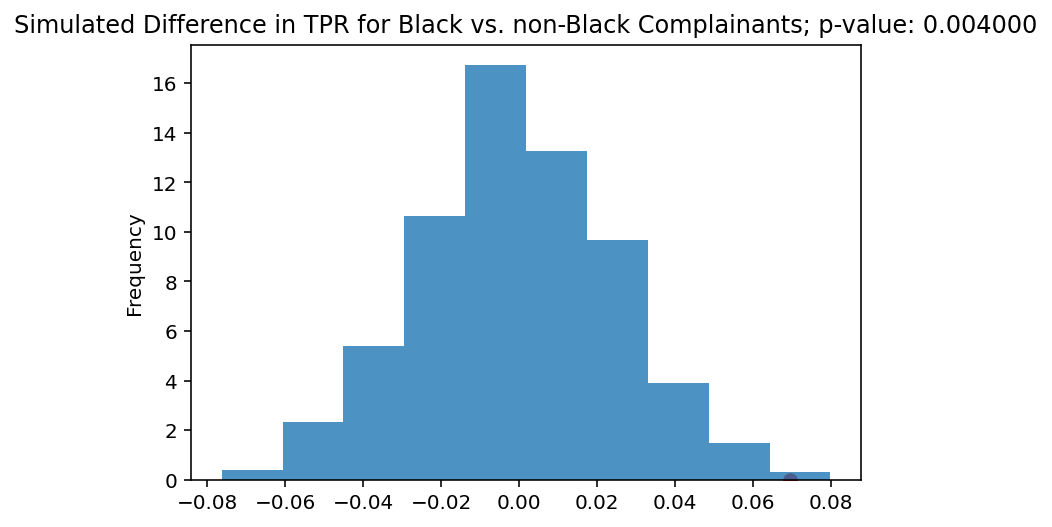

In [688]:
title = 'Simulated Difference in TPR for Black vs. non-Black Complainants'
title += '; p-value: %f' % p_value_tpr
(pd.Series(test_statistics_tpr)).plot(kind='hist', density=True, alpha=0.8, title=title)
plt.scatter(tpr_black - tpr_nb, 0, color='red', s=40)
plt.show()

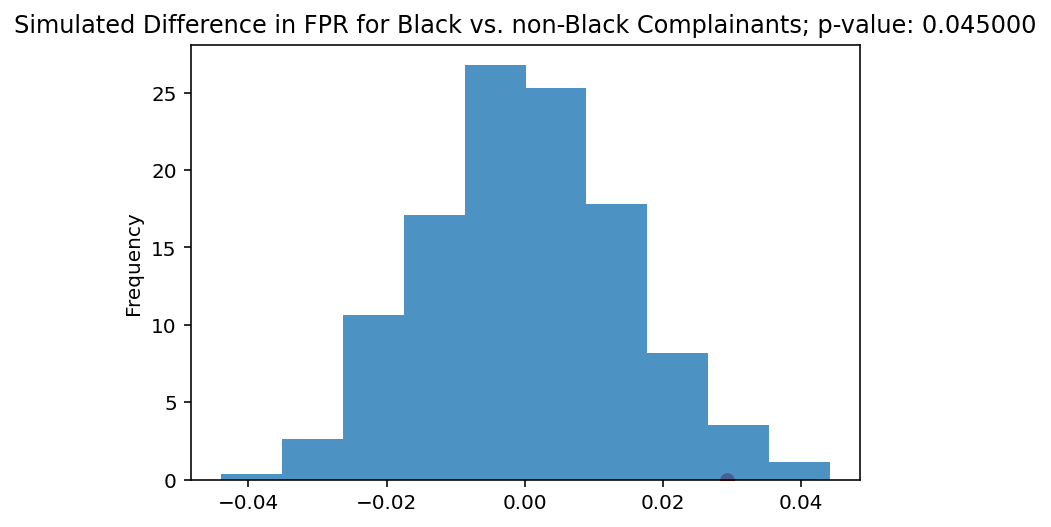

In [689]:
title = 'Simulated Difference in FPR for Black vs. non-Black Complainants'
title += '; p-value: %f' % p_value_fpr
(pd.Series(test_statistics_fpr)).plot(kind='hist', density=True, alpha=0.8, title=title)
plt.scatter(fpr_black - fpr_nb, 0, color='red', s=40)
plt.show()

## Predictive Value Parity

The new model also doesn’t satisfy predictive value parity, despite the original model satisfying it. The differences in both negative and positive predictive value parity between Black and non-Black complaints slightly widened (less than a percent difference), making these differences significant from 0 when conducting a permutation test with 0.05 significance level.  

In [808]:
c1_black = model_results_le.loc[(model_results_le.classification == 1) & (model_results_le.black==True)]
sub_black = c1_black.loc[(c1_black.substantiated==True)]
ppv_black = sub_black.shape[0] / c1_black.shape[0]
c1_nb = model_results_le.loc[(model_results_le.classification == 1) & (model_results_le.black!=True)]
sub_nb = c1_nb.loc[(c1_nb.substantiated==True)]
ppv_nb = sub_nb.shape[0] / c1_nb.shape[0]
print("Observed Difference in Positive Predictive Value for Black complainants vs. non-Black complainants: {}".format(ppv_black - ppv_nb))

Observed Difference in Positive Predictive Value for Black complainants vs. non-Black complainants: -0.04361756664388239


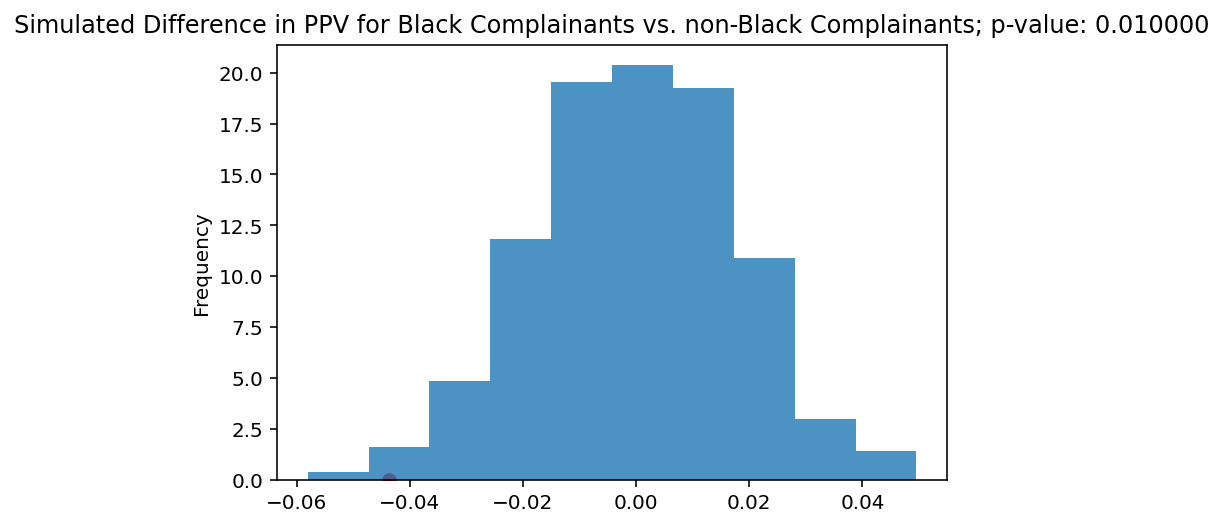

In [691]:
def permutation_test_ppv(df, observed, n_repetitions):
    test_statistics = []
    for _ in range(n_repetitions):
        # shuffle the statistic of interest
        shuffled_values = (df['black'].sample(replace=False, frac=1)
            .reset_index(drop=True))
        # put them in a table
        shuffled = df.copy().reset_index()
        shuffled['Shuffled Values'] = shuffled_values
        c1_black = shuffled.loc[(shuffled.classification == 1) & (shuffled['Shuffled Values']==True)]
        sub_black = c1_black.loc[(c1_black.substantiated==True)]
        ppv_black = sub_black.shape[0] / c1_black.shape[0]
        c1_nb = shuffled.loc[(shuffled.classification == 1) & (shuffled['Shuffled Values']!=True)]
        sub_nb = c1_nb.loc[(c1_nb.substantiated==True)]
        ppv_nb = sub_nb.shape[0] / c1_nb.shape[0]
        difference = ppv_black - ppv_nb
        test_statistics.append(difference)
    
    # p-value to see if got any thing even smaller than observed
    p_value_neg = np.count_nonzero(np.array(test_statistics) < min([observed, observed*-1])) / n_repetitions
    # p-value to see if got any thing even bigger than observed
    p_value_pos = np.count_nonzero(np.array(test_statistics) > max([observed, observed*-1])) / n_repetitions
    p_value = p_value_neg + p_value_pos
    return (test_statistics, p_value)
test_stats_ppv_eth, p_value_ppv_eth = permutation_test_ppv(model_results_le, ppv_black - ppv_nb, 1000 )
title = 'Simulated Difference in PPV for Black Complainants vs. non-Black Complainants'
title += '; p-value: %f' % p_value_ppv_eth
(pd.Series(test_stats_ppv_eth)).plot(kind='hist', density=True, alpha=0.8, title=title)
plt.scatter(ppv_black - ppv_nb, 0, color='red', s=40)
plt.show()

In [809]:
c0_black = model_results_le.loc[(model_results_le.classification == 0) & (model_results_le.black==True)]
unsub_black = c0_black.loc[(c0_black.substantiated==False)]
npv_black = unsub_black.shape[0] / c0_black.shape[0]
c0_nb = model_results_le.loc[(model_results_le.classification == 0) & (model_results_le.black!=True)]
unsub_nb = c0_nb.loc[(c0_nb.substantiated==False)]
npv_nb = unsub_nb.shape[0] / c0_nb.shape[0]
print("Observed Difference in Negative Predictive Value for Black complainants vs. non-Black complainants: {}".format(npv_black - npv_nb))

Observed Difference in Negative Predictive Value for Black complainants vs. non-Black complainants: 0.02605181915526744


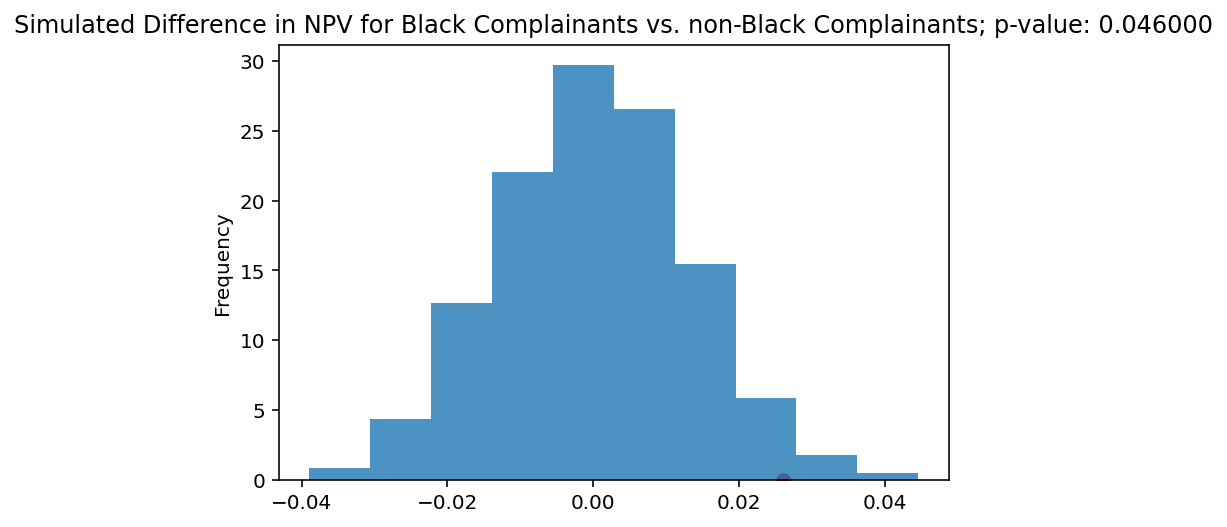

In [693]:
def permutation_test_npv(df, observed, n_repetitions):
    test_statistics = []
    for _ in range(n_repetitions):
        # shuffle the statistic of interest
        shuffled_values = (df['black'].sample(replace=False, frac=1)
            .reset_index(drop=True))
        # put them in a table
        shuffled = df.copy().reset_index()
        shuffled['Shuffled Values'] = shuffled_values
        c0_black = shuffled.loc[(shuffled.classification == 0) & (shuffled['Shuffled Values']==True)]
        unsub_black = c0_black.loc[(c0_black.substantiated==False)]
        npv_black = unsub_black.shape[0] / c0_black.shape[0]
        c0_nb = shuffled.loc[(shuffled.classification == 0) & (shuffled['Shuffled Values']!=True)]
        unsub_nb = c0_nb.loc[(c0_nb.substantiated==False)]
        npv_nb = unsub_nb.shape[0] / c0_nb.shape[0]
        difference = npv_black - npv_nb
        test_statistics.append(difference)
        # difference in means:
    # p-value to see if got any thing even smaller than observed
    p_value_neg = np.count_nonzero(np.array(test_statistics) < min([observed, observed*-1])) / n_repetitions
    # p-value to see if got any thing even bigger than observed
    p_value_pos = np.count_nonzero(np.array(test_statistics) > max([observed, observed*-1])) / n_repetitions
    p_value = p_value_neg + p_value_pos
    return (test_statistics, p_value)
test_stats_npv_eth, p_value_npv_eth = permutation_test_npv(model_results_le, npv_black - npv_nb, 1000 )
title = 'Simulated Difference in NPV for Black Complainants vs. non-Black Complainants'
title += '; p-value: %f' % p_value_npv_eth
(pd.Series(test_stats_npv_eth)).plot(kind='hist', density=True, alpha=0.8, title=title)
plt.scatter(npv_black - npv_nb, 0, color='red', s=40)
plt.show()

## Explanation

It is clear that the decorrelation was unsuccessful and seemed to benefit Black complainants more than non-Black complainants. Below are some speculations as to why either this preprocessing is not suitable for this context or dataset or why the methodology didn’t yield the expected results: 

- The distributions of the remaining features (allegation, type of complaint, rank of officer, and time elapsed between opening and closing of complaint) were too similar across groups. Thus, the decorrelation process would not have changed the data enough to make the expected impact. 
- Another factor could be that many of the dropped attributes, including the protected classes and the unordered categorical variables, could have high predictive power. When simply looking at the logistic regression coefficients of the original model, some of the higher coefficients are from the unordered categorical variables. These variables could have helped the model somehow differentiate between Black and non-Black complainants, leading to the original violations in parity. Since these variables are excluded in the new dataset/model, the new model doesn’t fix the unfairness seen in the original model. Instead, the new model reverses the unfairness in favor of Black complainants. 
- The attributes that may have put Black complainants at a disadvantage in the eyes of the model could be the same attributes that had to be excluded from the new model. Additionally, the distributions of features that were retained could have been too similar across complainant ethnicity. So, when decorrelating these retained features, Black complainants could have benefitted more. 
- The features that led to an “unlevel playing field” across complainant ethnicity could have been the excluded features, so “leveling the playing field” with the retained features could have led to the overcorrection in differences in substantiation rate. 
- The initial belief that the decision is dependent on complainant ethnicity could have been grossly incorrect. While demographic parity in the dataset is clearly violated, this may not be because of the dataset, but because of some unseen factors not present in the data. If this were true, then this entire exercise of analyzing the dataset, creating a model, and auditing the model could have been useless. The information that most greatly influences the CCRB’s decision making could be excluded in the dataset.   
- Performing decorrelation is likely more successful with more groups and more features. Since there are only two groups to create the median distribution from, and the dataset had a limited amount of attributes appropriate for this process, the statistical degradation could have been too severe.

# Works Cited

Feldman, M., Friedler, S. A., Moeller, J., Scheidegger, C., &amp; Venkatasubramanian, S. (2015). Certifying and removing disparate impact. Proceedings of the 21th ACM SIGKDD International Conference on Knowledge Discovery and Data Mining. https://doi.org/10.1145/2783258.2783311 

Fraenkel, A. (n.d.). Fairness &amp; Algorithmic Decision making. 8. COMPAS Analysis II - Fairness &amp; Algorithmic Decision Making. Retrieved June 9, 2022, from https://afraenkel.github.io/fairness-book/content/08-compas-2.html 

Julia Angwin, J. L. (2016, May 23). Machine bias. ProPublica. Retrieved June 9, 2022, from https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing 

Katz, D. M., II, M. J. B., &amp; Blackman, J. (n.d.). A general approach for predicting the behavior of the Supreme Court of the United States. PLOS ONE. Retrieved June 9, 2022, from https://journals.plos.org/plosone/article?id=10.1371%2Fjournal.pone.0174698 

New York City Department of City Planning | Population Division. (2022, February 9). Dynamics of racial/Hispanic composition in NYC neighborhoods. ArcGIS StoryMaps. Retrieved June 9, 2022, from https://storymaps.arcgis.com/stories/46a91a58447d4024afd00771eec1dd23 

New York City Police Department. (2021, January 15). Disciplinary System Penalty Guidelines. Retrieved June 9, 2022, from https://www1.nyc.gov/assets/nypd/downloads/pdf/public_information/disciplinary-system-penalty-guidelines-effective-01-15-2021-compete-.pdf 

The NYPD Files. (2020, July 7). ProPublica Data Store. https://www.propublica.org/datastore/dataset/civilian-complaints-against-new-york-city-police-oﬀicers

Title 38-A: Civilian Complaint Review Board - New York City. (2018, January 1). Retrieved June 9, 2022, from https://www1.nyc.gov/assets/ccrb/downloads/pdf/about_pdf/Title38-A_20210526.pdf 

Zander, J. A. (2018, June 29). Duties of the NYPD ranks. Work. Retrieved June 9, 2022, from https://work.chron.com/duties-nypd-ranks-21851.html 